# Feature Engineering

Feature engineering involves the selection, manipulation and transformation of raw data into features used in supervised learning. The purpose of feature engineering and selection is to improve the performance of machine-learning algorithms. In consequence, model accuracy on unseen data should be improved. 

This notebook includes:
- Outlier and missing analysis: detect (MAD z-score) and missing data.
- Missing‐value handling: null impulation, mean impulation, median impulation, multivariate Imputation, K-Nearest Neighbor, interpolation & extrapolation.
- Creating features: residual according to high correlations, golden combination characteristic, target encoding, rolling means, polynomial features
- Feature selection: mutual info, target correlation, correlated features, feature outliers, null importance
- Results evaluation: benchmark model - TabPFN regression

## 1. Configuration and Preparation

### 1.1 Parameters
These parameters not only enable parameterization of this Notebook, but also allow us to easily call and execute Jupyter Notebooks in other notebooks via papermill.

In [1]:
# parameters
# for function call, please set this cell tag as 'parameters'
parameters = dict(
    missing_outlier_r_threshold = 7, # threshold for the removal of rows with lage number of missing and outliers, recommend 6 or 7
    missing_outlier_c_threshold = 200, # threshold for the removal of columns with lage number of missing and outliers, recommend 200
    impute_method = 'interp', # imputation methods: 'zero', 'mean', 'median', 'mice', 'knn', 'interp'
    corr_method = 'spearman', # 'pearson' or 'spearman'
    corr_threshold = 0.9, # correlation threshold to determine close related feature pairs, recommend 0.8, 0.85 or 0.9
    target_corr_threshold = 0.01, # correlation threshold to determine close related feature pairs, recommend 0.01 or 0.02
    null_importance_threshold = 90, # threshold for null importance, recommend 80 or 90
    OnlyOrigNumFeatures = True, # whether only provide the original numerical features for the learning
    KeepOrigNumFeatures = True, # whether keep original numerical features for the learning
    UseTimeSeries = False, # use the complete time series of trian and test data set
    RemoveMissingOutlier = False, # whether remove the rows and columns with a large number of missing and outlier values 
)

In [2]:
# assign and organize parameter values
missing_outlier_r_threshold = parameters['missing_outlier_r_threshold']
missing_outlier_c_threshold = parameters['missing_outlier_c_threshold']
impute_method = parameters['impute_method']
corr_method = parameters['corr_method']
corr_threshold = parameters['corr_threshold']
target_corr_threshold = parameters['target_corr_threshold']
null_importance_threshold = parameters['null_importance_threshold']
OnlyOrigNumFeatures = parameters['OnlyOrigNumFeatures']
KeepOrigNumFeatures = parameters['KeepOrigNumFeatures']
UseTimeSeries = parameters['UseTimeSeries']
RemoveMissingOutlier = parameters['RemoveMissingOutlier']

if OnlyOrigNumFeatures:
    KeepOrigNumFeatures = True    

### 1.2 Configuration

In [3]:
# configuration
# paths
INPUT_DIR = "../data/" 
X_TRAIN_PATH = f"{INPUT_DIR}X_train_NHkHMNU.csv"
X_TEST_PATH  = f"{INPUT_DIR}X_test_final.csv"
Y_TRAIN_PATH = f"{INPUT_DIR}y_train_ZAN5mwg.csv"

# seed for random number
RANDOM_STATE = 47

In [4]:
# relevant feature lists
drop_features = ['DE_NET_IMPORT', 'FR_DE_EXCHANGE', 'FR_NET_IMPORT']
country_features = ["TEMP", "RAIN", "WIND", "GAS", "COAL", "HYDRO", "NUCLEAR", "SOLAR", "WINDPOW", "CONSUMPTION", "RESIDUAL_LOAD", "NET_EXPORT"]
eu_features = ['GAS_RET', 'COAL_RET', 'CARBON_RET']
de_features = ['DE_' + x for x in country_features] + ["DE_LIGNITE"]
fr_features = ['FR_' + x for x in country_features]
weather_measures = ['TEMP', 'RAIN', 'WIND']
weather_features = ['DE_' + x for x in weather_measures] + ['FR_' + x for x in weather_measures]
use_measures = ["CONSUMPTION", "RESIDUAL_LOAD", "NET_EXPORT"]
use_features = ['DE_' + x for x in use_measures] + ['FR_' + x for x in use_measures] + ["DE_FR_EXCHANGE"]
renew_energy = ["HYDRO", "SOLAR", "WINDPOW"]
renew_features = ['DE_' + x for x in renew_energy] + ['FR_' + x for x in renew_energy]
nonrenew_energy = ["GAS", "COAL", "NUCLEAR"]
nonrenew_features = ['DE_' + x for x in nonrenew_energy] + ['FR_' + x for x in nonrenew_energy] + ["DE_LIGNITE"]

### 1.3 Imports and load data

In [5]:
# imports of libraries and functions
import numpy as np
import pandas as pd
import lightgbm as lgb
import scipy
import seaborn as sns
import scrapbook as sb
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings

from fancyimpute import IterativeImputer, KNN, SimpleFill
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error, r2_score
from tabpfn import TabPFNRegressor

warnings.filterwarnings('ignore')

In [6]:
# load data and preparing
X_train = pd.read_csv(X_TRAIN_PATH)
X_test = pd.read_csv(X_TEST_PATH)
y_train = pd.read_csv(Y_TRAIN_PATH)

assert "ID" in X_train.columns and "ID" in y_train.columns, "ID column must exist in both X_train and y_train"

# dropped due to very high correlation according to EDA
X_y_train = X_train.merge(y_train, on="ID", how="left").drop(drop_features, axis=1)
X_train_test = pd.concat([X_train, X_test], ignore_index=True).drop(drop_features, axis=1)
X_test.drop(drop_features, axis=1, inplace=True)

In [7]:
# country info and simple target encoding on countries
if "COUNTRY" in X_train_test.columns:
    print(X_train_test["COUNTRY"].value_counts(dropna=False))
else:
    print("No COUNTRY column found.")

if OnlyOrigNumFeatures :
    orig_num_cols = [x for x in X_train_test.columns if x not in ['DAY_ID', 'COUNTRY']]    

target_mean_de = X_y_train.loc[X_y_train['COUNTRY'] == 'DE', 'TARGET'].mean()
target_mean_fr = X_y_train.loc[X_y_train['COUNTRY'] == 'FR', 'TARGET'].mean()
X_y_train['COUNTRY_MEAN'] = X_y_train['COUNTRY'].apply(lambda x: target_mean_de if x == 'DE' else target_mean_fr)
X_train_test['COUNTRY_MEAN'] = X_train_test['COUNTRY'].apply(lambda x: target_mean_de if x == 'DE' else target_mean_fr)

NON_FEATURE = {"ID", "COUNTRY", "TARGET"}
num_cols = [c for c in X_train_test.columns if c not in NON_FEATURE and pd.api.types.is_numeric_dtype(X_train_test[c])]
print("Numeric feature count:", len(num_cols))

COUNTRY
FR    1216
DE     932
Name: count, dtype: int64
Numeric feature count: 31


## 2. Outlier Treatment

Outlier treatment based on MAD z-score, which is a modified z-score that uses the Median Absolute Deviation (MAD) instead of the standard deviation to detect outliers in a dataset, making it more robust against extreme values. To calculate it, you find the median of the data, then find the median of the absolute deviations from that median, and use that value to scale the differences from the median for each data point. As the target has too many outliers, we do not cap the outliers, but only to remove the noise rows with a large number of missing and outlier values.

In [8]:
# cap outliers based on MAD z-score
def mad_winsorize(df, cols=None, thresh=3.5, constant=1.4826, eps=1e-9):
    x = df.copy()
    if cols is None:
        cols = x.select_dtypes(include=np.number).columns
    med = x[cols].median()
    mad = (x[cols] - med).abs().median()
    scale = constant * mad + eps
    lo = med - thresh * scale
    hi = med + thresh * scale
    x[cols] = x[cols].clip(lower=lo, upper=hi, axis=1)
    return x

In [9]:
# statisic the missing and outliers in each row of dataframe
def row_missing_and_outliers(
    df: pd.DataFrame,
    cols=None,             
    method: str = "mad",    
    thresh: float = 3.5,   
    constant: float = 1.4826,
    eps: float = 1e-9,
):
    x = df.copy()
    n_missing = x.isna().sum(axis=1)

    if cols is None:
        cols = x.select_dtypes(include=np.number).columns.tolist()
    if not cols:
        outlier_counts = pd.Series(0, index=x.index, name="n_outliers")
        return pd.DataFrame({"n_missing": n_missing, "n_outliers": outlier_counts})

    if method.lower() == "z":
        mu = x[cols].mean()
        sd = x[cols].std(ddof=0).replace(0, np.nan)
        scale = sd + eps
        z = (x[cols] - mu) / scale

    elif method.lower() == "mad":
        med = x[cols].median()
        mad = (x[cols] - med).abs().median().replace(0, np.nan)
        scale = constant * mad + eps
        z = (x[cols] - med) / scale
    else:
        raise ValueError("method must be 'mad' or 'z'")

    out_mask = z.abs() > thresh
    out_mask = out_mask & x[cols].notna()
    n_outliers = out_mask.sum(axis=1)

    return pd.DataFrame({
        'ID': x.ID,
        "n_missing": n_missing,
        "n_outliers": n_outliers
    })

In [10]:
# statisic the missing and outliers in each column of dataframe
def column_missing_and_outliers(
    df: pd.DataFrame,
    cols=None,                
    method: str = "mad",      
    thresh: float = 3.5,      
    constant: float = 1.4826, 
    eps: float = 1e-9
) -> pd.DataFrame:
    x = df.copy()

    n_missing = x.isna().sum(axis=0)
    n_total = len(x)
    frac_missing = n_missing / max(n_total, 1)

    if cols is None:
        num_col = x.select_dtypes(include=np.number).columns.tolist()
    else:
        num_col = list(cols)

    n_outliers = pd.Series(np.nan, index=x.columns, dtype=float)
    frac_outliers = pd.Series(np.nan, index=x.columns, dtype=float)
    center_used = pd.Series(np.nan, index=x.columns, dtype=float)
    scale_used  = pd.Series(np.nan, index=x.columns, dtype=float)

    if len(num_col) > 0:
        if method.lower() == "z":
            center = x[num_col].mean(axis=0)
            scale = x[num_col].std(axis=0, ddof=0)
        elif method.lower() == "mad":
            center = x[num_col].median(axis=0)
            mad = (x[num_col] - center).abs().median(axis=0)
            scale = constant * mad
        else:
            raise ValueError("method must be 'mad' or 'z'")

        scale = scale.replace(0, np.nan)
        
        Z = (x[num_col] - center) / (scale + eps)
        valid = x[num_col].notna() & np.isfinite(Z)
        out_mask = valid & (Z.abs() > thresh)

        n_out = out_mask.sum(axis=0)
        denom = valid.sum(axis=0).replace(0, np.nan)

        n_outliers.loc[num_col] = n_out
        frac_outliers.loc[num_col] = (n_out / denom)
        center_used.loc[num_col] = center
        scale_used.loc[num_col]  = scale
        
    res = pd.DataFrame({
        #'column': num_col,
        "n_missing": n_missing,
        "frac_missing": frac_missing,
        "n_outliers": n_outliers,
        "frac_outliers": frac_outliers,
        "center": center_used,
        "scale": scale_used     
    })
    return res

In [11]:
# count the rows and columns with a large number of missing and outlier values
r_missing_outlier = row_missing_and_outliers(X_y_train)
drop_rows = list(r_missing_outlier.loc[(r_missing_outlier.n_missing + r_missing_outlier.n_outliers) > missing_outlier_r_threshold, 'ID'])
print(f"The number of rows with a large count of missing and outlier values is {len(drop_rows)}")

c_missing_outlier = column_missing_and_outliers(X_y_train)
drop_columns = list(c_missing_outlier.loc[(c_missing_outlier.n_missing + c_missing_outlier.n_outliers) > missing_outlier_c_threshold].index)
print(f"The number of columns with a large count of missing and outlier values is {len(drop_columns)}")
if 'TARGET' in drop_columns:
    drop_columns.remove('TARGET')
display(drop_columns)

The number of rows with a large count of missing and outlier values is 35
The number of columns with a large count of missing and outlier values is 1


['FR_COAL']

In [12]:
# remove the rows with a large number of missing and outlier values
display((X_train.shape, y_train.shape, X_train_test.shape, X_y_train.shape))

if RemoveMissingOutlier and len(drop_rows) > 0:
    X_train = X_train[~X_train['ID'].isin(drop_rows)]
    y_train = y_train[~y_train['ID'].isin(drop_rows)]
    X_train_test = X_train_test[~X_train_test['ID'].isin(drop_rows)]
    X_y_train = X_y_train[~X_y_train['ID'].isin(drop_rows)]

    display((X_train.shape, y_train.shape, X_train_test.shape, X_y_train.shape))

((1494, 35), (1494, 2), (2148, 33), (1494, 34))

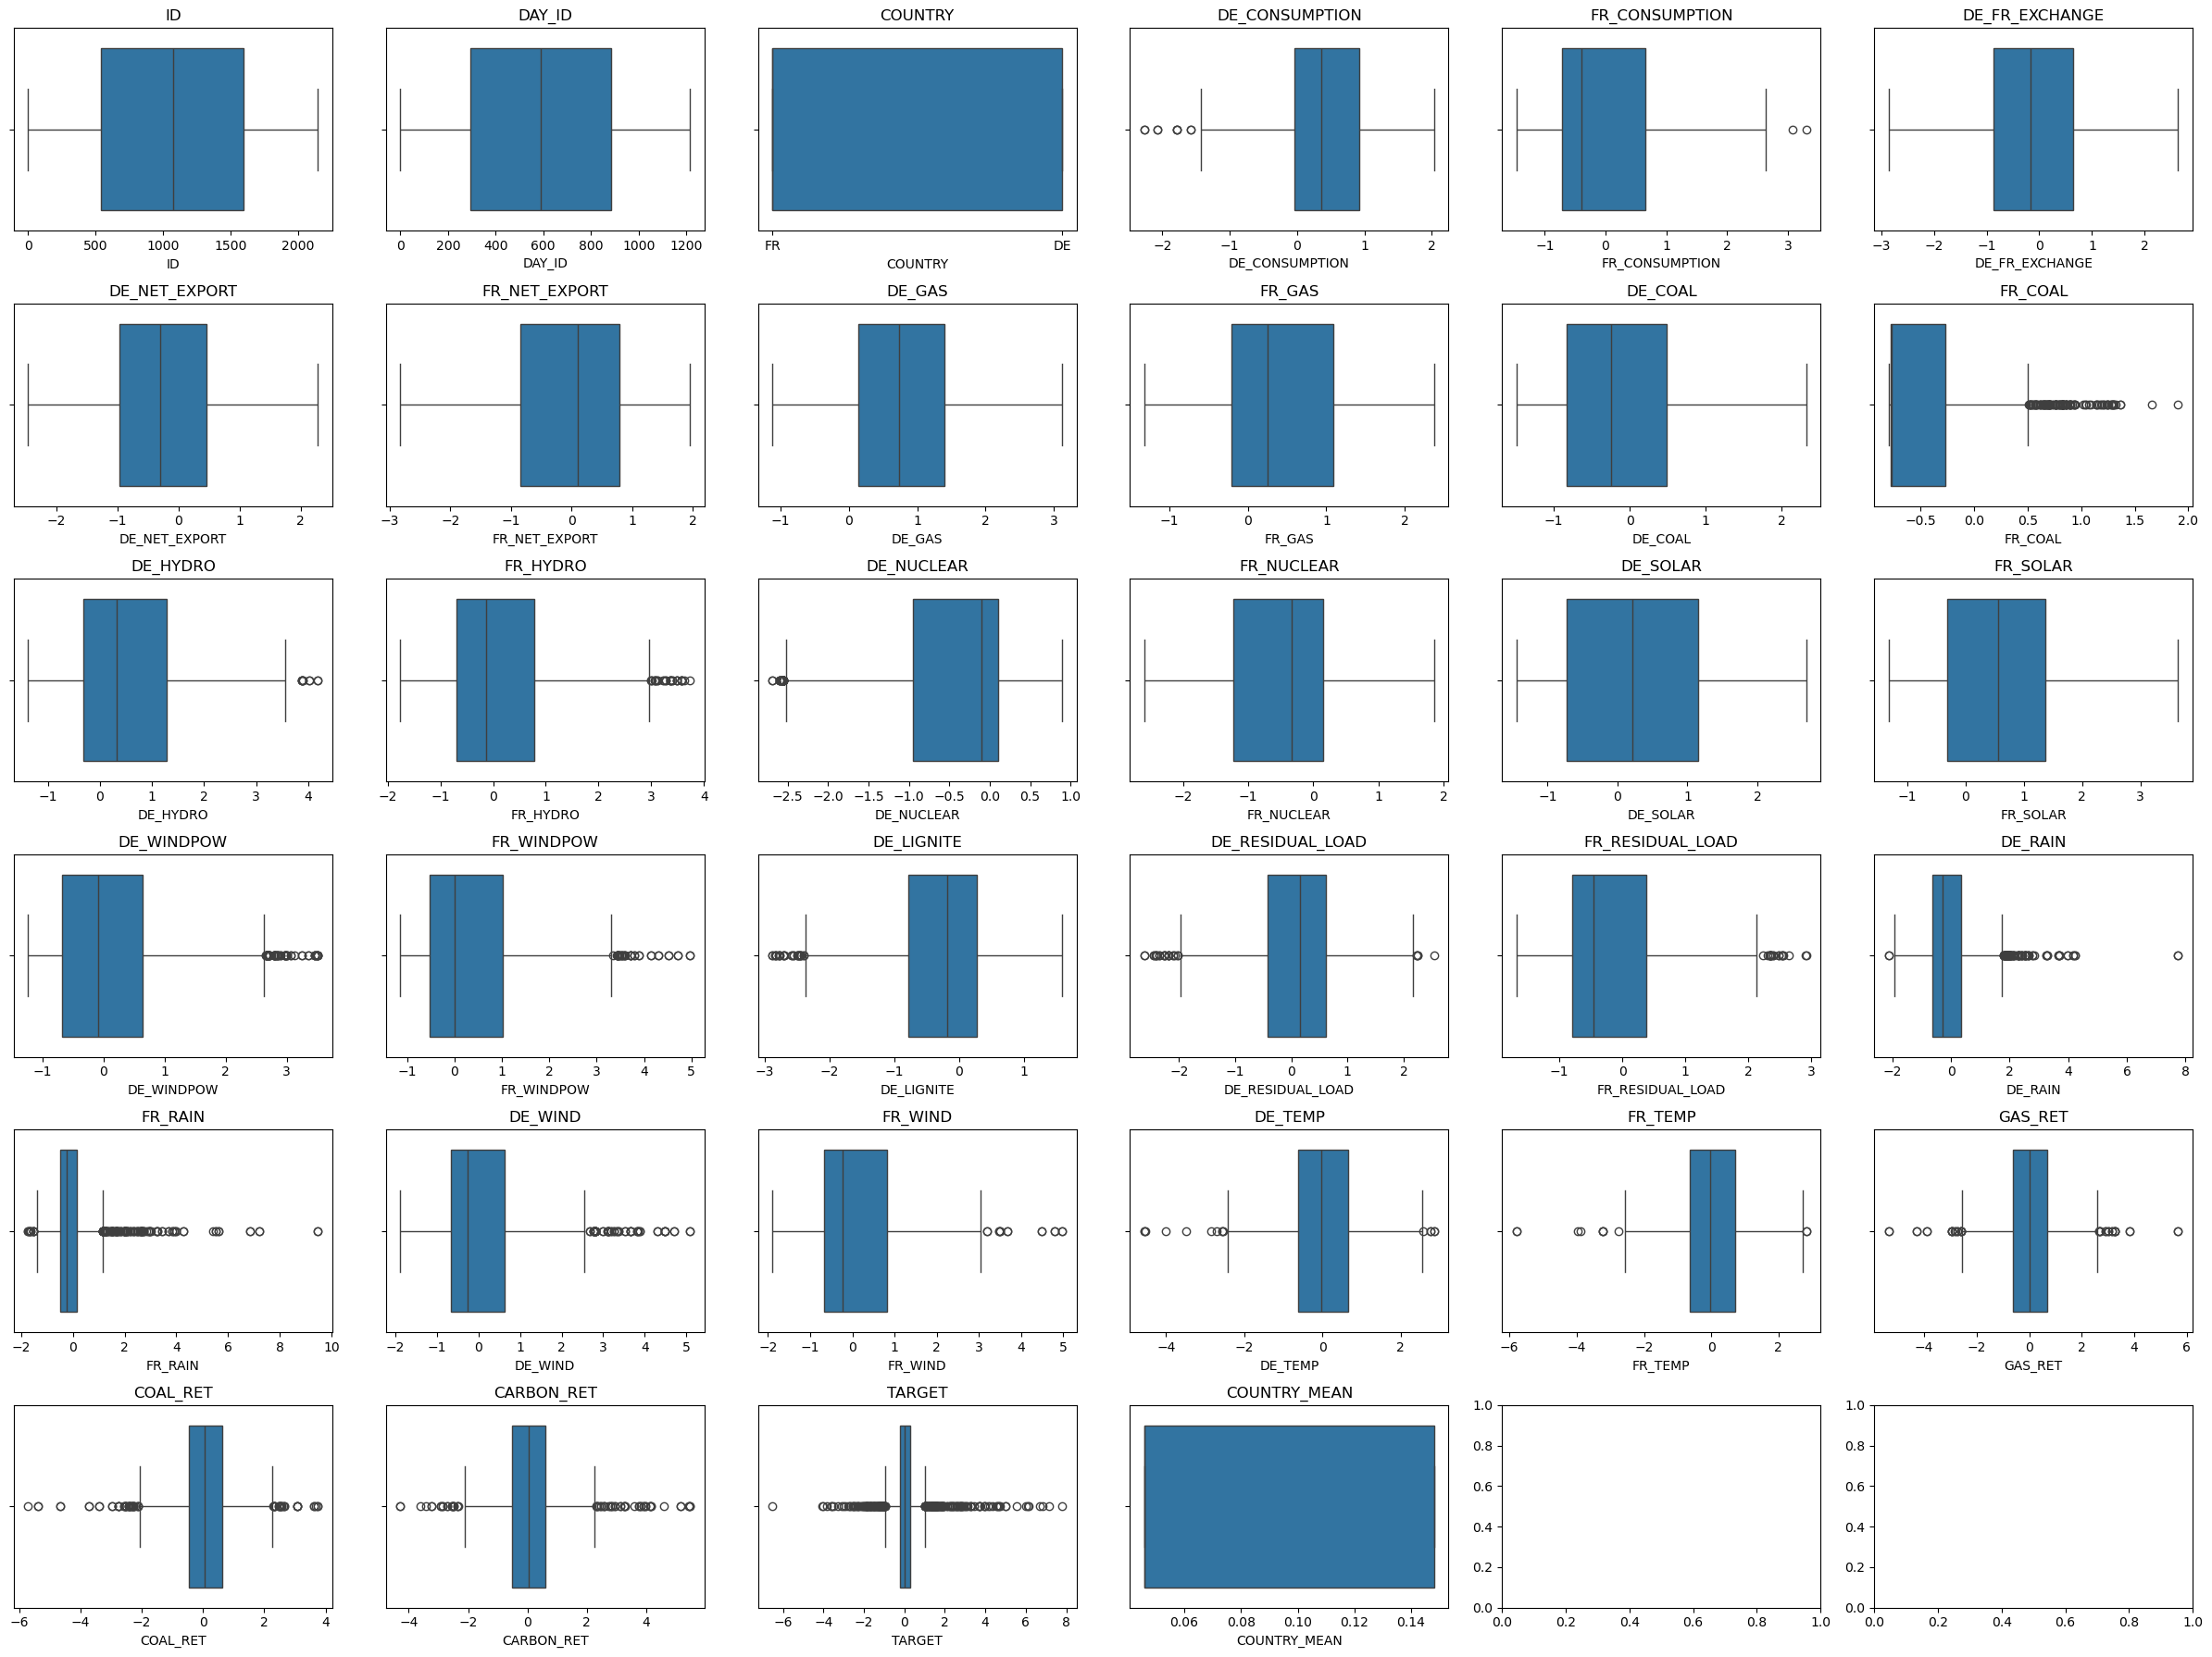

In [13]:
# plot the outliers for each feature
plots = [(c, X_y_train[c]) for c in X_y_train.columns]

K = len(plots)
N = math.ceil(math.sqrt(K))            
M = math.ceil(K / N)                 

fig, axes = plt.subplots(M, N, figsize=(N*4, M*3), squeeze=False)
axes = axes.ravel()

for i, (name, s) in enumerate(plots):
    sns.boxplot(x=s, ax=axes[i])
    axes[i].set_title(f"{name}")

plt.tight_layout()
plt.show()

## 3. Handling Missing Values

### 3.1 Check Missing Values 

List features with missing values:


missing_count  missing_pct
DE_NET_EXPORT             171     0.079609
DE_WIND                   134     0.062384
FR_WIND                   134     0.062384
DE_TEMP                   134     0.062384
FR_TEMP                   134     0.062384
FR_RAIN                   134     0.062384
DE_RAIN                   134     0.062384
FR_NET_EXPORT              94     0.043762
DE_FR_EXCHANGE             34     0.015829

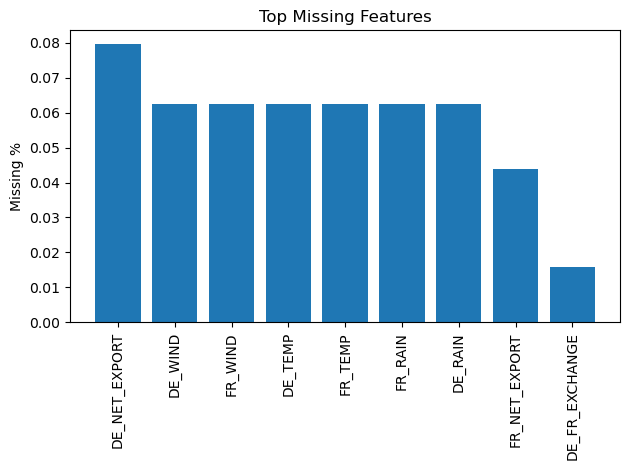

In [14]:
# list top missing features
missing_counts = X_train_test.isna().sum().sort_values(ascending=False)
missing_pct = (missing_counts / len(X_train_test)).sort_values(ascending=False)
missing_df = pd.DataFrame({"missing_count": missing_counts, "missing_pct": missing_pct})
print("List features with missing values:")
display(missing_df[missing_df.missing_count	> 0])

# plot top missing features — single figure
top_miss = missing_df.head((missing_df['missing_count'] > 0).sum())
plt.figure()
plt.bar(top_miss.index.astype(str), top_miss["missing_pct"].values)
plt.xticks(rotation=90)
plt.ylabel("Missing %")
plt.title("Top Missing Features")
plt.tight_layout()
plt.show()

### 3.2 Imputation of missing values

In the missing-data impulation section, we implemented and compared the following methods: null impulation ('zero'), mean impulation ('mean'), median impulation ('median'), multivariate Imputation ('mice'), K-Nearest Neighbor ('knn'), interpolation & extrapolation ('interp'). We also distinguished between two impulation scenarios: (1) the standard approach where the training and test sets are handled separately, and (2) combining the two datasets to form a complete time series and performing impulation on that series. In the second scenario, we first standardize the time series and then interpolate, finally merging the results back into the original datasets keyed by 'DAY_ID'. This ensures that feature values for the same day are consistent, thereby preserving the original data logic.

In [15]:
# impute missing values with different methods
imp_cols = num_cols[:-1]

if UseTimeSeries:
    # provide and sort complete time series of train and test data set
    df_timeseries = X_train_test[imp_cols].copy()
    df_timeseries.sort_values("DAY_ID", inplace=True)
    df_timeseries.drop_duplicates(inplace=True)
    print(f"There are {len(df_timeseries[df_timeseries.duplicated(subset=['DAY_ID'], keep=False)])} duplicates in the time series")

    # impute missing values
    X_filled_zero = SimpleFill(fill_method='zero').fit_transform(df_timeseries)
    X_filled_mean = SimpleFill(fill_method='mean').fit_transform(df_timeseries)
    X_filled_median = SimpleFill(fill_method='median').fit_transform(df_timeseries)
    X_filled_mice = IterativeImputer(max_iter=10, random_state=RANDOM_STATE).fit_transform(df_timeseries)
    X_filled_knn = KNN(k=5).fit_transform(df_timeseries)
    X_filled_interp = df_timeseries.interpolate(method='polynomial', order=2, limit_direction="both")
    X_filled_interp = X_filled_interp.interpolate(method="linear", limit_direction="both")

    X_filled_zero = pd.DataFrame(X_filled_zero, columns=imp_cols)
    X_filled_mean = pd.DataFrame(X_filled_mean, columns=imp_cols)
    X_filled_median = pd.DataFrame(X_filled_median, columns=imp_cols)
    X_filled_mice = pd.DataFrame(X_filled_mice, columns=imp_cols)
    X_filled_knn = pd.DataFrame(X_filled_knn, columns=imp_cols)
else:
    X_train_imp = X_train[['ID']].merge(X_train_test, on='ID', how='left')[imp_cols]
    X_test_imp = X_test[['ID']].merge(X_train_test, on='ID', how='left')[imp_cols]
    
    X_tr_filled_zero = SimpleFill(fill_method='zero').fit_transform(X_train_imp)
    X_tr_filled_mean = SimpleFill(fill_method='mean').fit_transform(X_train_imp)
    X_tr_filled_median = SimpleFill(fill_method='median').fit_transform(X_train_imp)
    X_tr_filled_mice = IterativeImputer(max_iter=10, random_state=RANDOM_STATE).fit_transform(X_train_imp)
    X_tr_filled_knn = KNN(k=5).fit_transform(X_train_imp)
    X_tr_filled_interp = X_train.interpolate(method='polynomial',order=3).fillna(0.0)
    
    X_tr_filled_zero = pd.DataFrame(X_tr_filled_zero, columns=imp_cols)
    X_tr_filled_mean = pd.DataFrame(X_tr_filled_mean, columns=imp_cols)
    X_tr_filled_median = pd.DataFrame(X_tr_filled_median, columns=imp_cols)
    X_tr_filled_mice = pd.DataFrame(X_tr_filled_mice, columns=imp_cols)
    X_tr_filled_knn = pd.DataFrame(X_tr_filled_knn, columns=imp_cols)

    X_te_filled_zero = SimpleFill(fill_method='zero').fit_transform(X_test_imp)
    X_te_filled_mean = SimpleFill(fill_method='mean').fit_transform(X_test_imp)
    X_te_filled_median = SimpleFill(fill_method='median').fit_transform(X_test_imp)
    X_te_filled_mice = IterativeImputer(max_iter=10, random_state=RANDOM_STATE).fit_transform(X_test_imp)
    X_te_filled_knn = KNN(k=5).fit_transform(X_test_imp)
    X_te_filled_interp = X_test.interpolate(method='polynomial',order=3)

    X_te_filled_zero = pd.DataFrame(X_te_filled_zero, columns=imp_cols)
    X_te_filled_mean = pd.DataFrame(X_te_filled_mean, columns=imp_cols)
    X_te_filled_median = pd.DataFrame(X_te_filled_median, columns=imp_cols)
    X_te_filled_mice = pd.DataFrame(X_te_filled_mice, columns=imp_cols)
    X_te_filled_knn = pd.DataFrame(X_te_filled_knn, columns=imp_cols)

    X_filled_zero = pd.concat([X_tr_filled_zero, X_te_filled_zero], ignore_index=True)
    X_filled_mean = pd.concat([X_tr_filled_mean, X_te_filled_mean], ignore_index=True)
    X_filled_median = pd.concat([X_tr_filled_median, X_te_filled_median], ignore_index=True)
    X_filled_mice = pd.concat([X_tr_filled_mice, X_te_filled_mice], ignore_index=True)
    X_filled_knn = pd.concat([X_tr_filled_knn, X_te_filled_knn], ignore_index=True)
    X_filled_interp = pd.concat([X_tr_filled_interp, X_te_filled_interp], ignore_index=True).fillna(0.0)

Imputing row 1/1494 with 1 missing, elapsed time: 0.225
Imputing row 101/1494 with 0 missing, elapsed time: 0.226
Imputing row 201/1494 with 0 missing, elapsed time: 0.227
Imputing row 301/1494 with 0 missing, elapsed time: 0.229
Imputing row 401/1494 with 0 missing, elapsed time: 0.229
Imputing row 501/1494 with 0 missing, elapsed time: 0.230
Imputing row 601/1494 with 0 missing, elapsed time: 0.231
Imputing row 701/1494 with 6 missing, elapsed time: 0.232
Imputing row 801/1494 with 2 missing, elapsed time: 0.233
Imputing row 901/1494 with 0 missing, elapsed time: 0.234
Imputing row 1001/1494 with 0 missing, elapsed time: 0.236
Imputing row 1101/1494 with 0 missing, elapsed time: 0.237
Imputing row 1201/1494 with 0 missing, elapsed time: 0.238
Imputing row 1301/1494 with 6 missing, elapsed time: 0.239
Imputing row 1401/1494 with 0 missing, elapsed time: 0.241
Imputing row 1/654 with 0 missing, elapsed time: 0.052
Imputing row 101/654 with 0 missing, elapsed time: 0.053
Imputing row 20

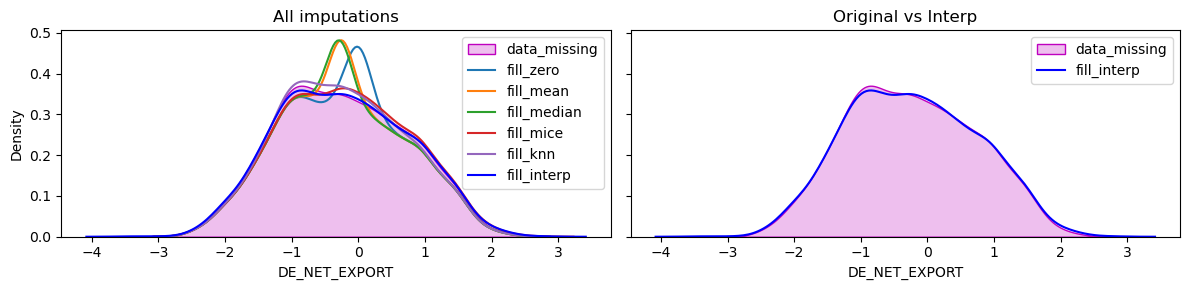

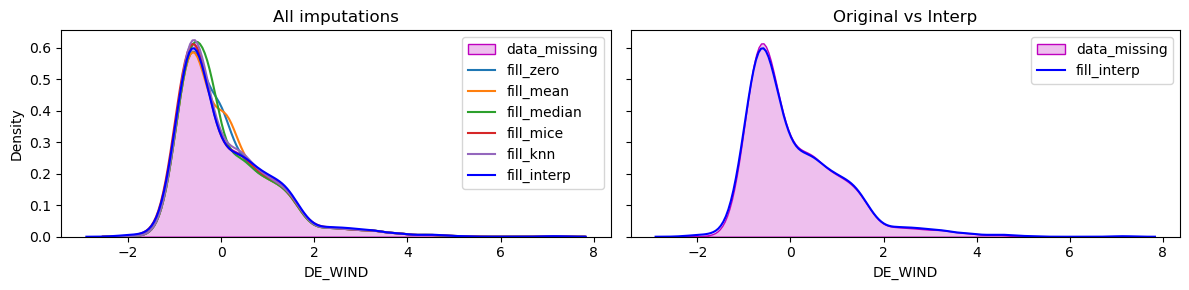

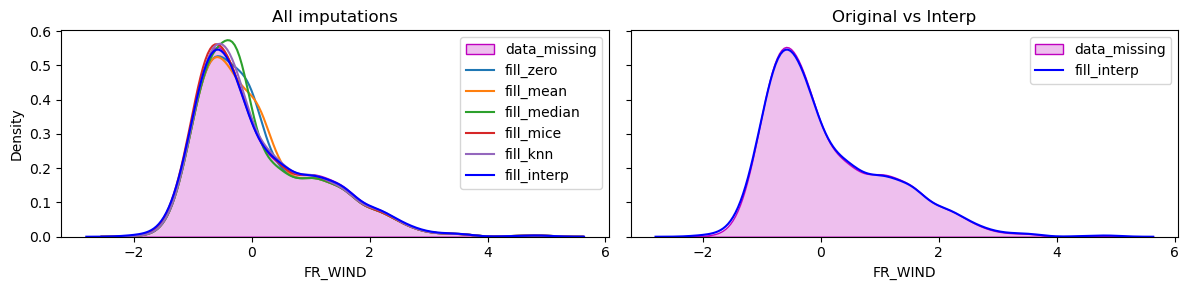

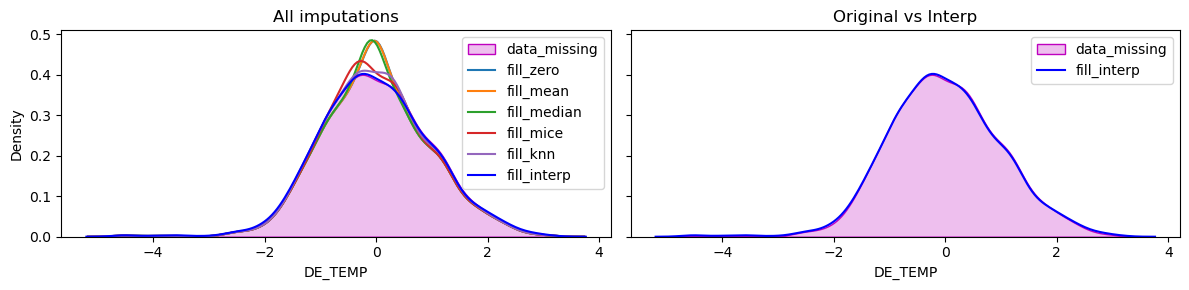

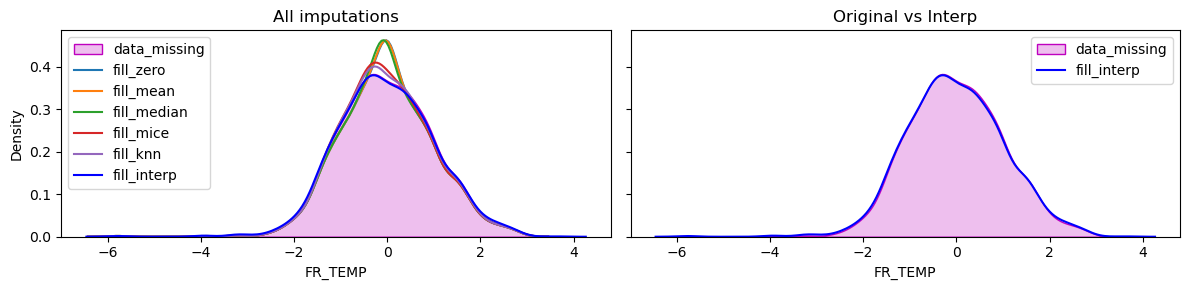

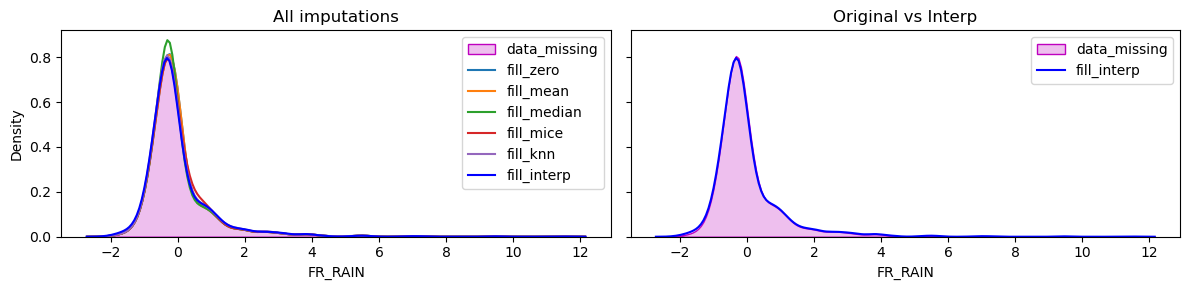

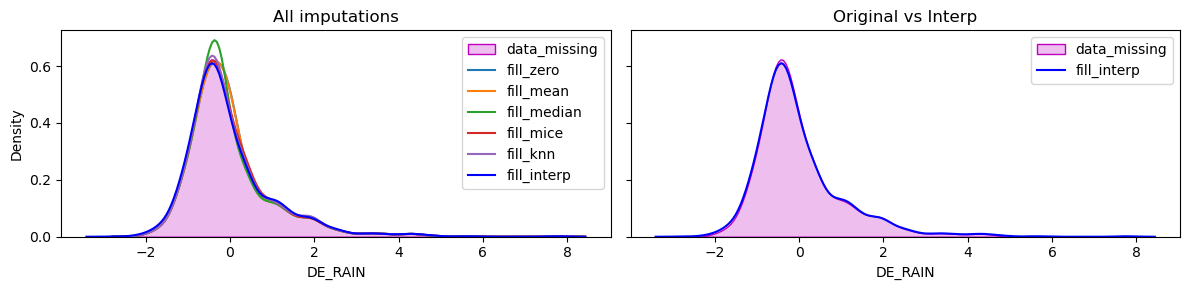

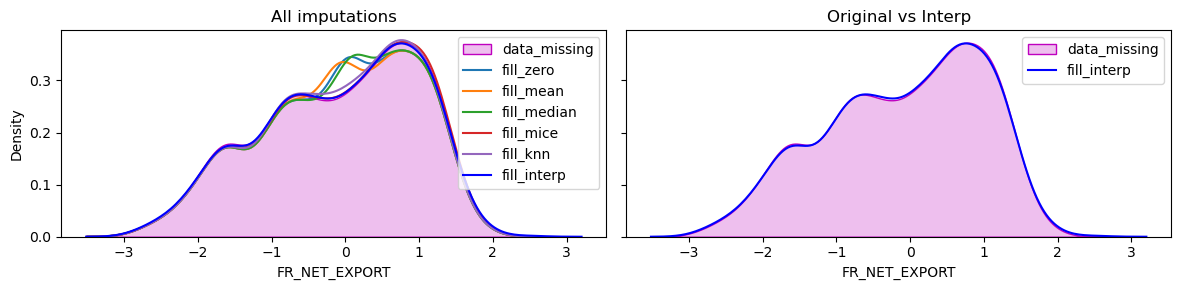

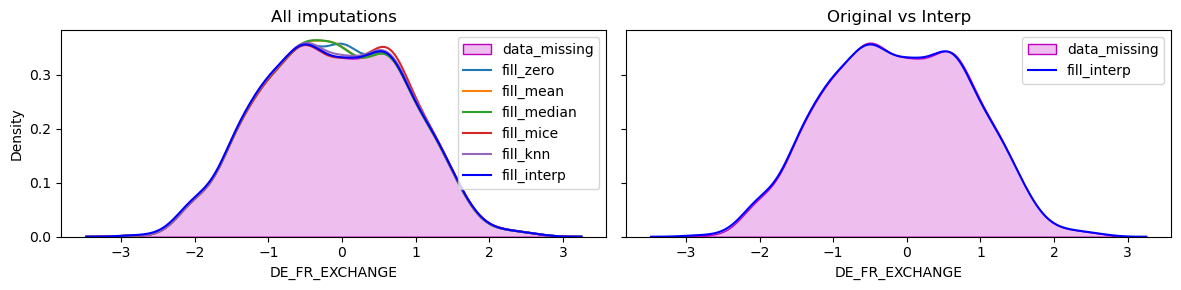

In [16]:
# plot distribution between features before and after imputation
for c in top_miss.index:
    fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharey=True)
    ax1, ax2 = axes
    
    sns.kdeplot(X_train_test[imp_cols][c], color='m', fill=True, ax=ax1, label='data_missing')
    sns.kdeplot(X_filled_zero[c],   ax=ax1, label='fill_zero')
    sns.kdeplot(X_filled_mean[c],   ax=ax1, label='fill_mean')
    sns.kdeplot(X_filled_median[c], ax=ax1, label='fill_median')
    sns.kdeplot(X_filled_mice[c],   ax=ax1, label='fill_mice')
    sns.kdeplot(X_filled_knn[c],    ax=ax1, label='fill_knn')
    sns.kdeplot(X_filled_interp[c], color='b', ax=ax1, label='fill_interp')
    ax1.set_xlabel(c)
    ax1.set_title('All imputations')
    ax1.legend()
    
    sns.kdeplot(X_train_test[c],    color='m', fill=True, ax=ax2, label='data_missing')
    sns.kdeplot(X_filled_interp[c], color='b', ax=ax2, label='fill_interp')
    ax2.set_xlabel(c)
    ax2.set_title('Original vs Interp')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [17]:
if impute_method == 'interp' and not UseTimeSeries:
    X_train_test_filled = pd.merge(X_train_test[['ID', 'COUNTRY_MEAN']], eval(f"X_filled_{impute_method}"), on='ID', how='left')
else:
    X_train_test_filled = pd.merge(X_train_test[['ID', 'DAY_ID', 'COUNTRY', 'COUNTRY_MEAN']], eval(f"X_filled_{impute_method}"), on='ID', how='left') 

### 3.3 Statistic after Imputation

Missing value count: 0
Correlation matrix shape: (32, 32)


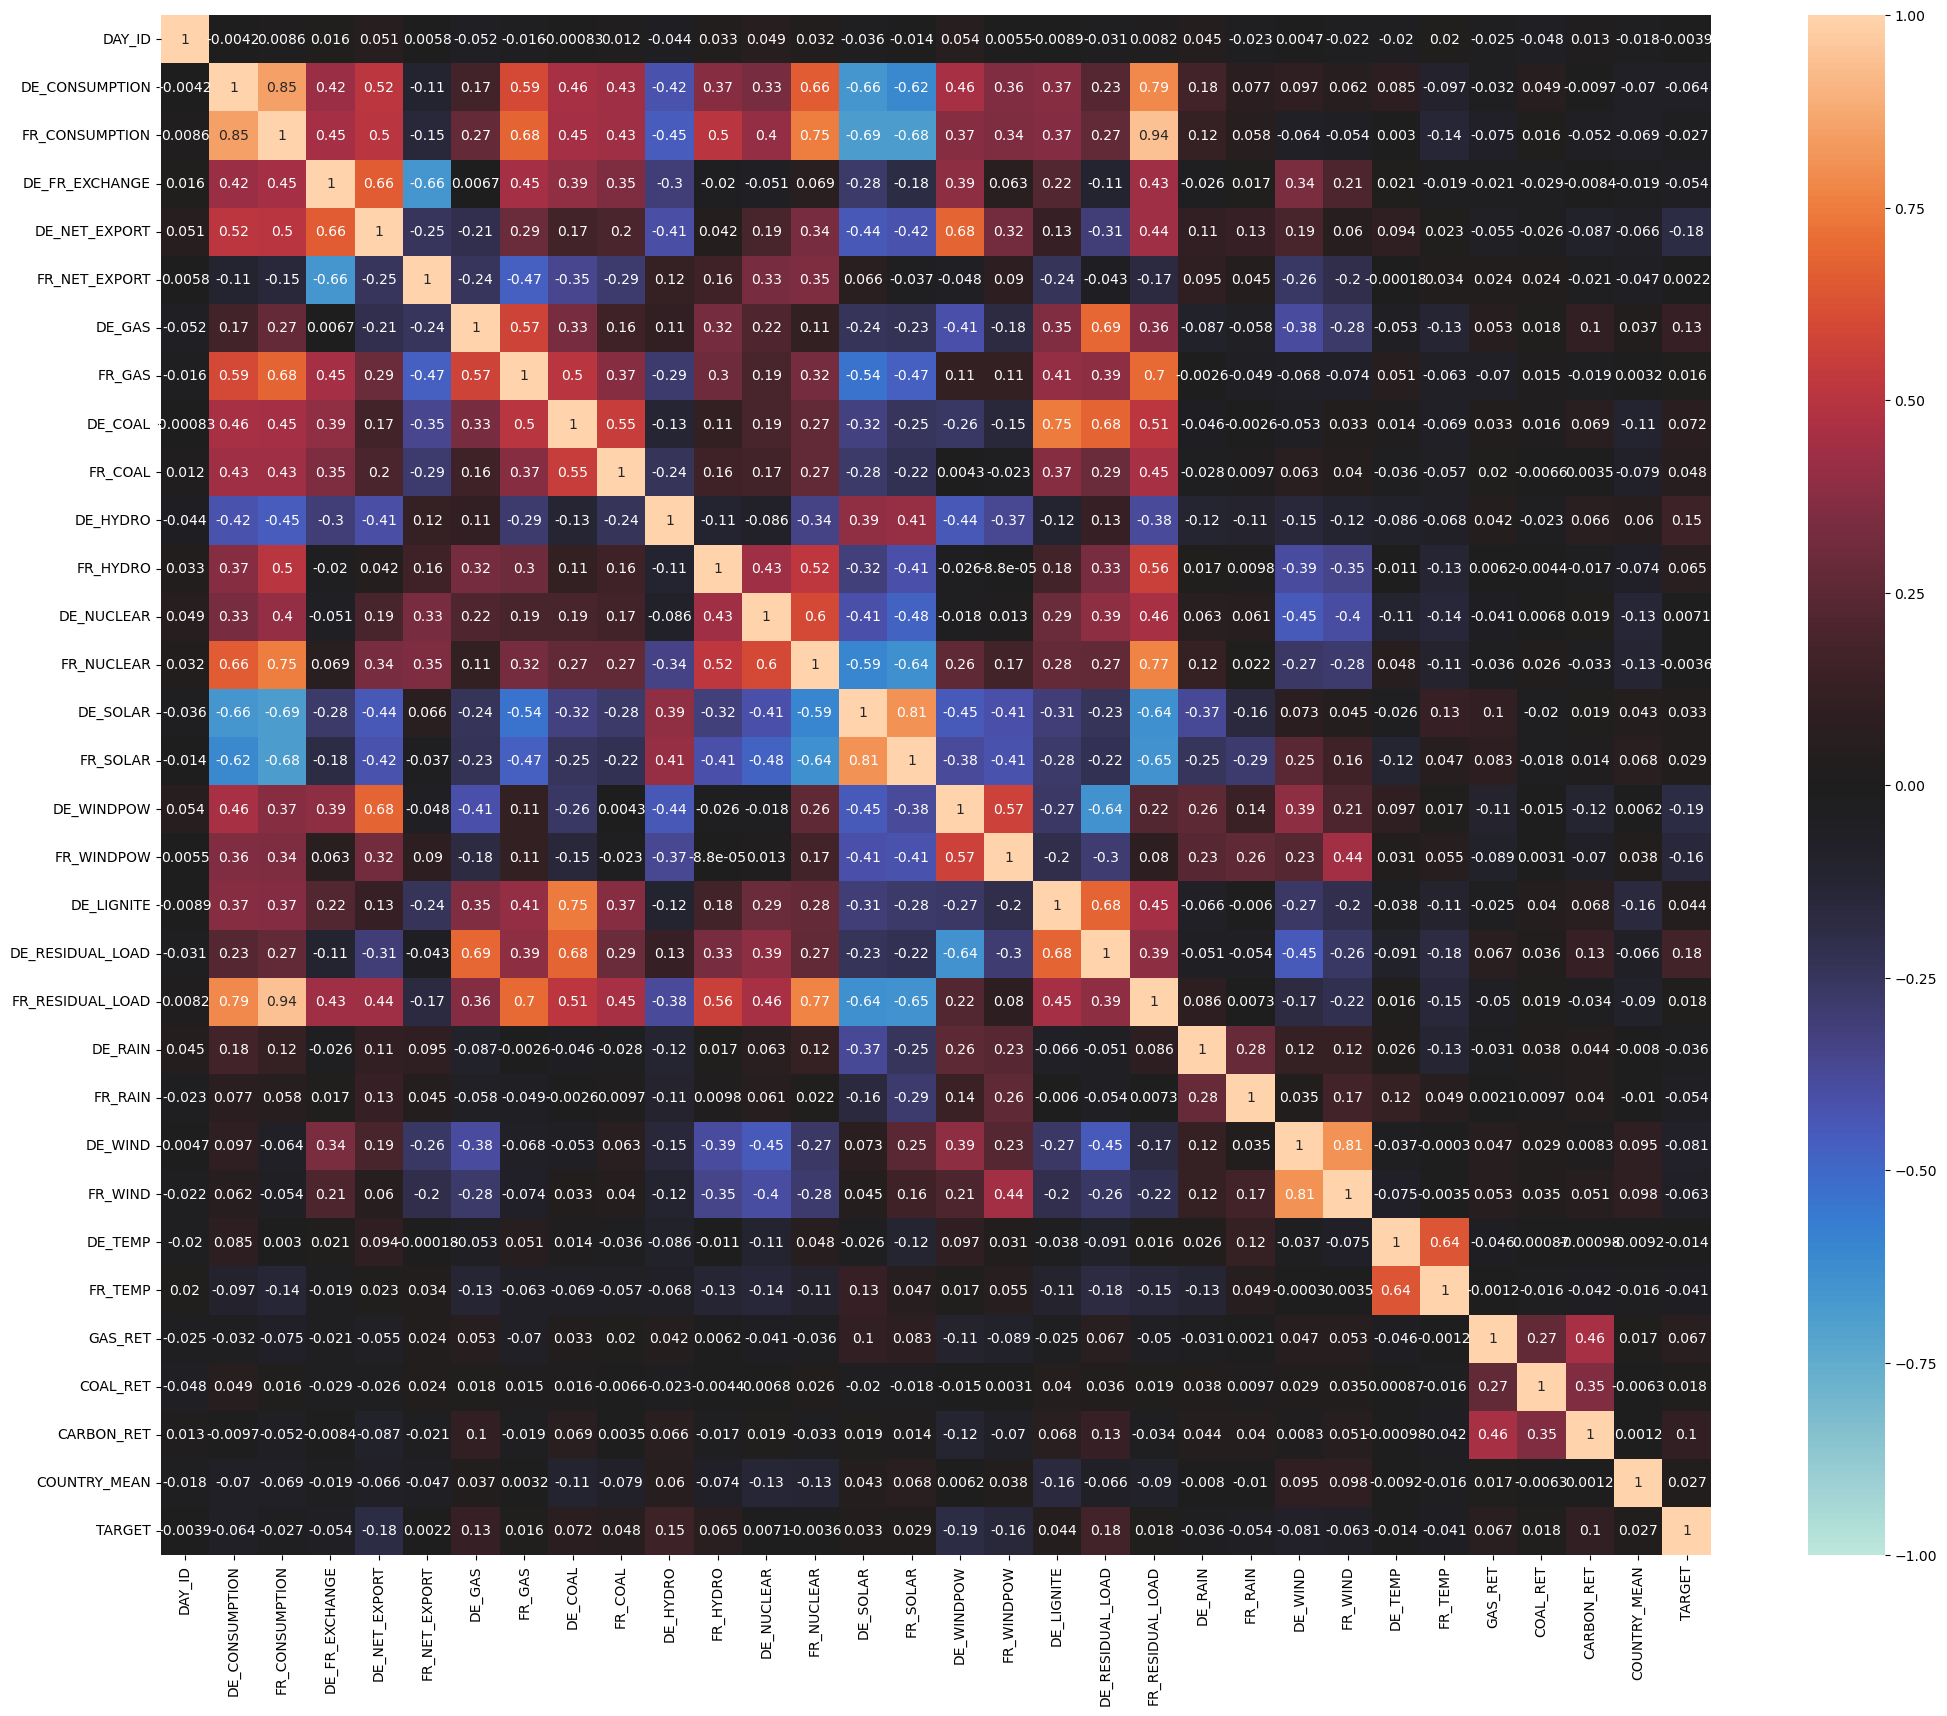

In [18]:
# plot heatmap of train data with target after imputation
X_y_train_filled = pd.merge(X_train_test_filled, y_train, on='ID', how='right')
print("Missing value count:", X_y_train_filled.isna().sum().sum())

corr = X_y_train_filled[num_cols + ["TARGET"]].corr(method=parameters['corr_method'])
print("Correlation matrix shape:", corr.shape)

plt.figure(figsize=[25,20])
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, center=0) 
plt.show()

In [19]:
# top absolute correlated pairs by |r|
pairs = []
cols = corr.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        r = corr.iloc[i, j]
        pairs.append((cols[i], cols[j], abs(r), r))
pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)[:20]
display(pd.DataFrame(pairs_sorted, columns=["feat1", "feat2", "|r|", "r"]))

feat1             feat2       |r|         r
0   FR_CONSUMPTION  FR_RESIDUAL_LOAD  0.941636  0.941636
1   DE_CONSUMPTION    FR_CONSUMPTION  0.846620  0.846620
2          DE_WIND           FR_WIND  0.812468  0.812468
3         DE_SOLAR          FR_SOLAR  0.808753  0.808753
4   DE_CONSUMPTION  FR_RESIDUAL_LOAD  0.786134  0.786134
5       FR_NUCLEAR  FR_RESIDUAL_LOAD  0.770119  0.770119
6   FR_CONSUMPTION        FR_NUCLEAR  0.751069  0.751069
7          DE_COAL        DE_LIGNITE  0.749457  0.749457
8           FR_GAS  FR_RESIDUAL_LOAD  0.702212  0.702212
9           DE_GAS  DE_RESIDUAL_LOAD  0.687535  0.687535
10  FR_CONSUMPTION          DE_SOLAR  0.686956 -0.686956
11  FR_CONSUMPTION          FR_SOLAR  0.683373 -0.683373
12  FR_CONSUMPTION            FR_GAS  0.682848  0.682848
13      DE_LIGNITE  DE_RESIDUAL_LOAD  0.682123  0.682123
14   DE_NET_EXPORT        DE_WINDPOW  0.680917  0.680917
15         DE_COAL  DE_RESIDUAL_LOAD  0.680489  0.680489
16  DE_FR_EXCHANGE     DE_NET_EXPORT  0.663661  0.663661
17  DE_CONSUMPTION          DE_SOLAR  0.659928 -0.659928
18  DE_FR_EXCHANGE     FR_NET_EXPORT  0.658739 -0.658739
19  DE_CONSUMPTION        FR_NUCLEAR  0.657896  0.657896

DE_RESIDUAL_LOAD    0.175793
DE_HYDRO            0.151367
DE_GAS              0.129905
CARBON_RET          0.104375
DE_COAL             0.072380
GAS_RET             0.066800
FR_HYDRO            0.064682
FR_COAL             0.048463
DE_LIGNITE          0.044180
DE_SOLAR            0.032740
FR_SOLAR            0.028839
COUNTRY_MEAN        0.027114
FR_RESIDUAL_LOAD    0.018241
COAL_RET            0.017573
FR_GAS              0.016334
DE_NUCLEAR          0.007052
FR_NET_EXPORT       0.002212
FR_NUCLEAR         -0.003619
DAY_ID             -0.003901
DE_TEMP            -0.013885
FR_CONSUMPTION     -0.027242
DE_RAIN            -0.036054
FR_TEMP            -0.041060
DE_FR_EXCHANGE     -0.054010
FR_RAIN            -0.054358
FR_WIND            -0.063296
DE_CONSUMPTION     -0.063617
DE_WIND            -0.081106
FR_WINDPOW         -0.155568
DE_NET_EXPORT      -0.182006
DE_WINDPOW         -0.185688
Name: TARGET, dtype: float64

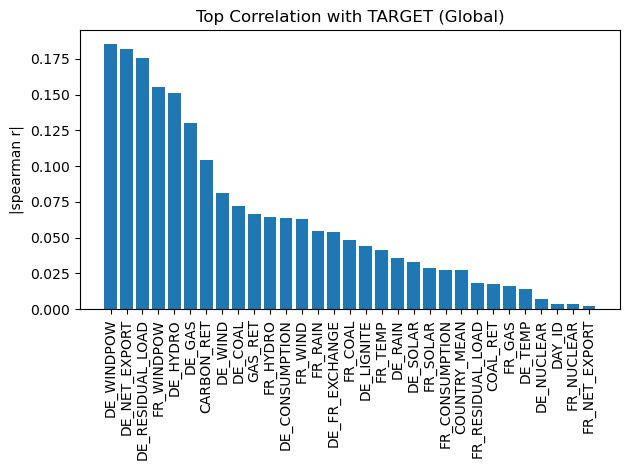

In [20]:
# calculate correlations between features and target, plot the top target correlations
assert "TARGET" in X_y_train_filled.columns, "TARGET missing after merge"
target_corr = X_y_train_filled[num_cols + ["TARGET"]].corr(method=parameters['corr_method'])["TARGET"].drop("TARGET").sort_values(ascending=False)
display(target_corr)

# Bar of absolute correlations (top-k)
tc_abs = target_corr.abs().sort_values(ascending=False)
plt.figure()
plt.bar(tc_abs.index.astype(str), tc_abs.values)
plt.xticks(rotation=90)
plt.ylabel(f"|{parameters['corr_method']} r|")
plt.title("Top Correlation with TARGET (Global)")
plt.tight_layout()
plt.show()

DE_RESIDUAL_LOAD    0.061609
DE_WINDPOW          0.057206
FR_NET_EXPORT       0.049533
DE_WIND             0.047792
DAY_ID              0.043862
DE_LIGNITE          0.043258
DE_RAIN             0.042631
DE_GAS              0.034452
FR_CONSUMPTION      0.029595
COUNTRY_MEAN        0.027362
DE_TEMP             0.022885
FR_WIND             0.020686
FR_WINDPOW          0.020285
FR_SOLAR            0.019679
DE_NUCLEAR          0.018527
GAS_RET             0.018324
FR_COAL             0.017179
DE_CONSUMPTION      0.016898
FR_NUCLEAR          0.015249
CARBON_RET          0.013482
DE_COAL             0.010798
FR_RAIN             0.008993
FR_HYDRO            0.005717
FR_GAS              0.003900
DE_HYDRO            0.003653
DE_SOLAR            0.002997
FR_TEMP             0.000545
DE_NET_EXPORT       0.000000
DE_FR_EXCHANGE      0.000000
FR_RESIDUAL_LOAD    0.000000
COAL_RET            0.000000
dtype: float64

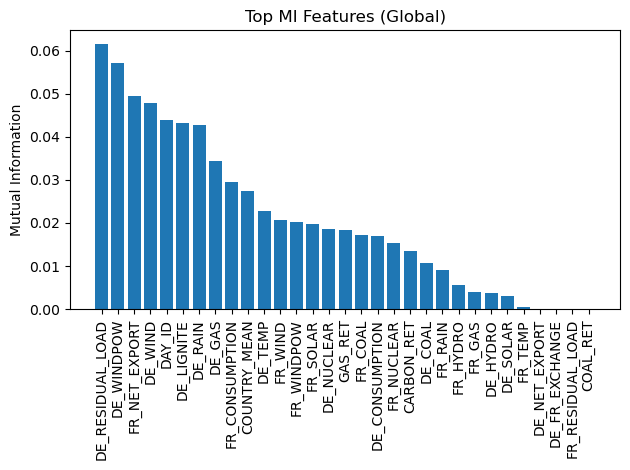

In [21]:
# mutual Information ranking (top-k) of the train data set after imputation
mi = mutual_info_regression(X_y_train_filled[num_cols], X_y_train_filled['TARGET'], random_state=RANDOM_STATE)
mi_series = pd.Series(mi, index=num_cols).sort_values(ascending=False)
display(mi_series)

plt.figure()
plt.bar(mi_series.index.astype(str), mi_series.values)
plt.xticks(rotation=90)
plt.ylabel("Mutual Information")
plt.title("Top MI Features (Global)")
plt.tight_layout()
plt.show()

Correlation matrix shape: (31, 31)


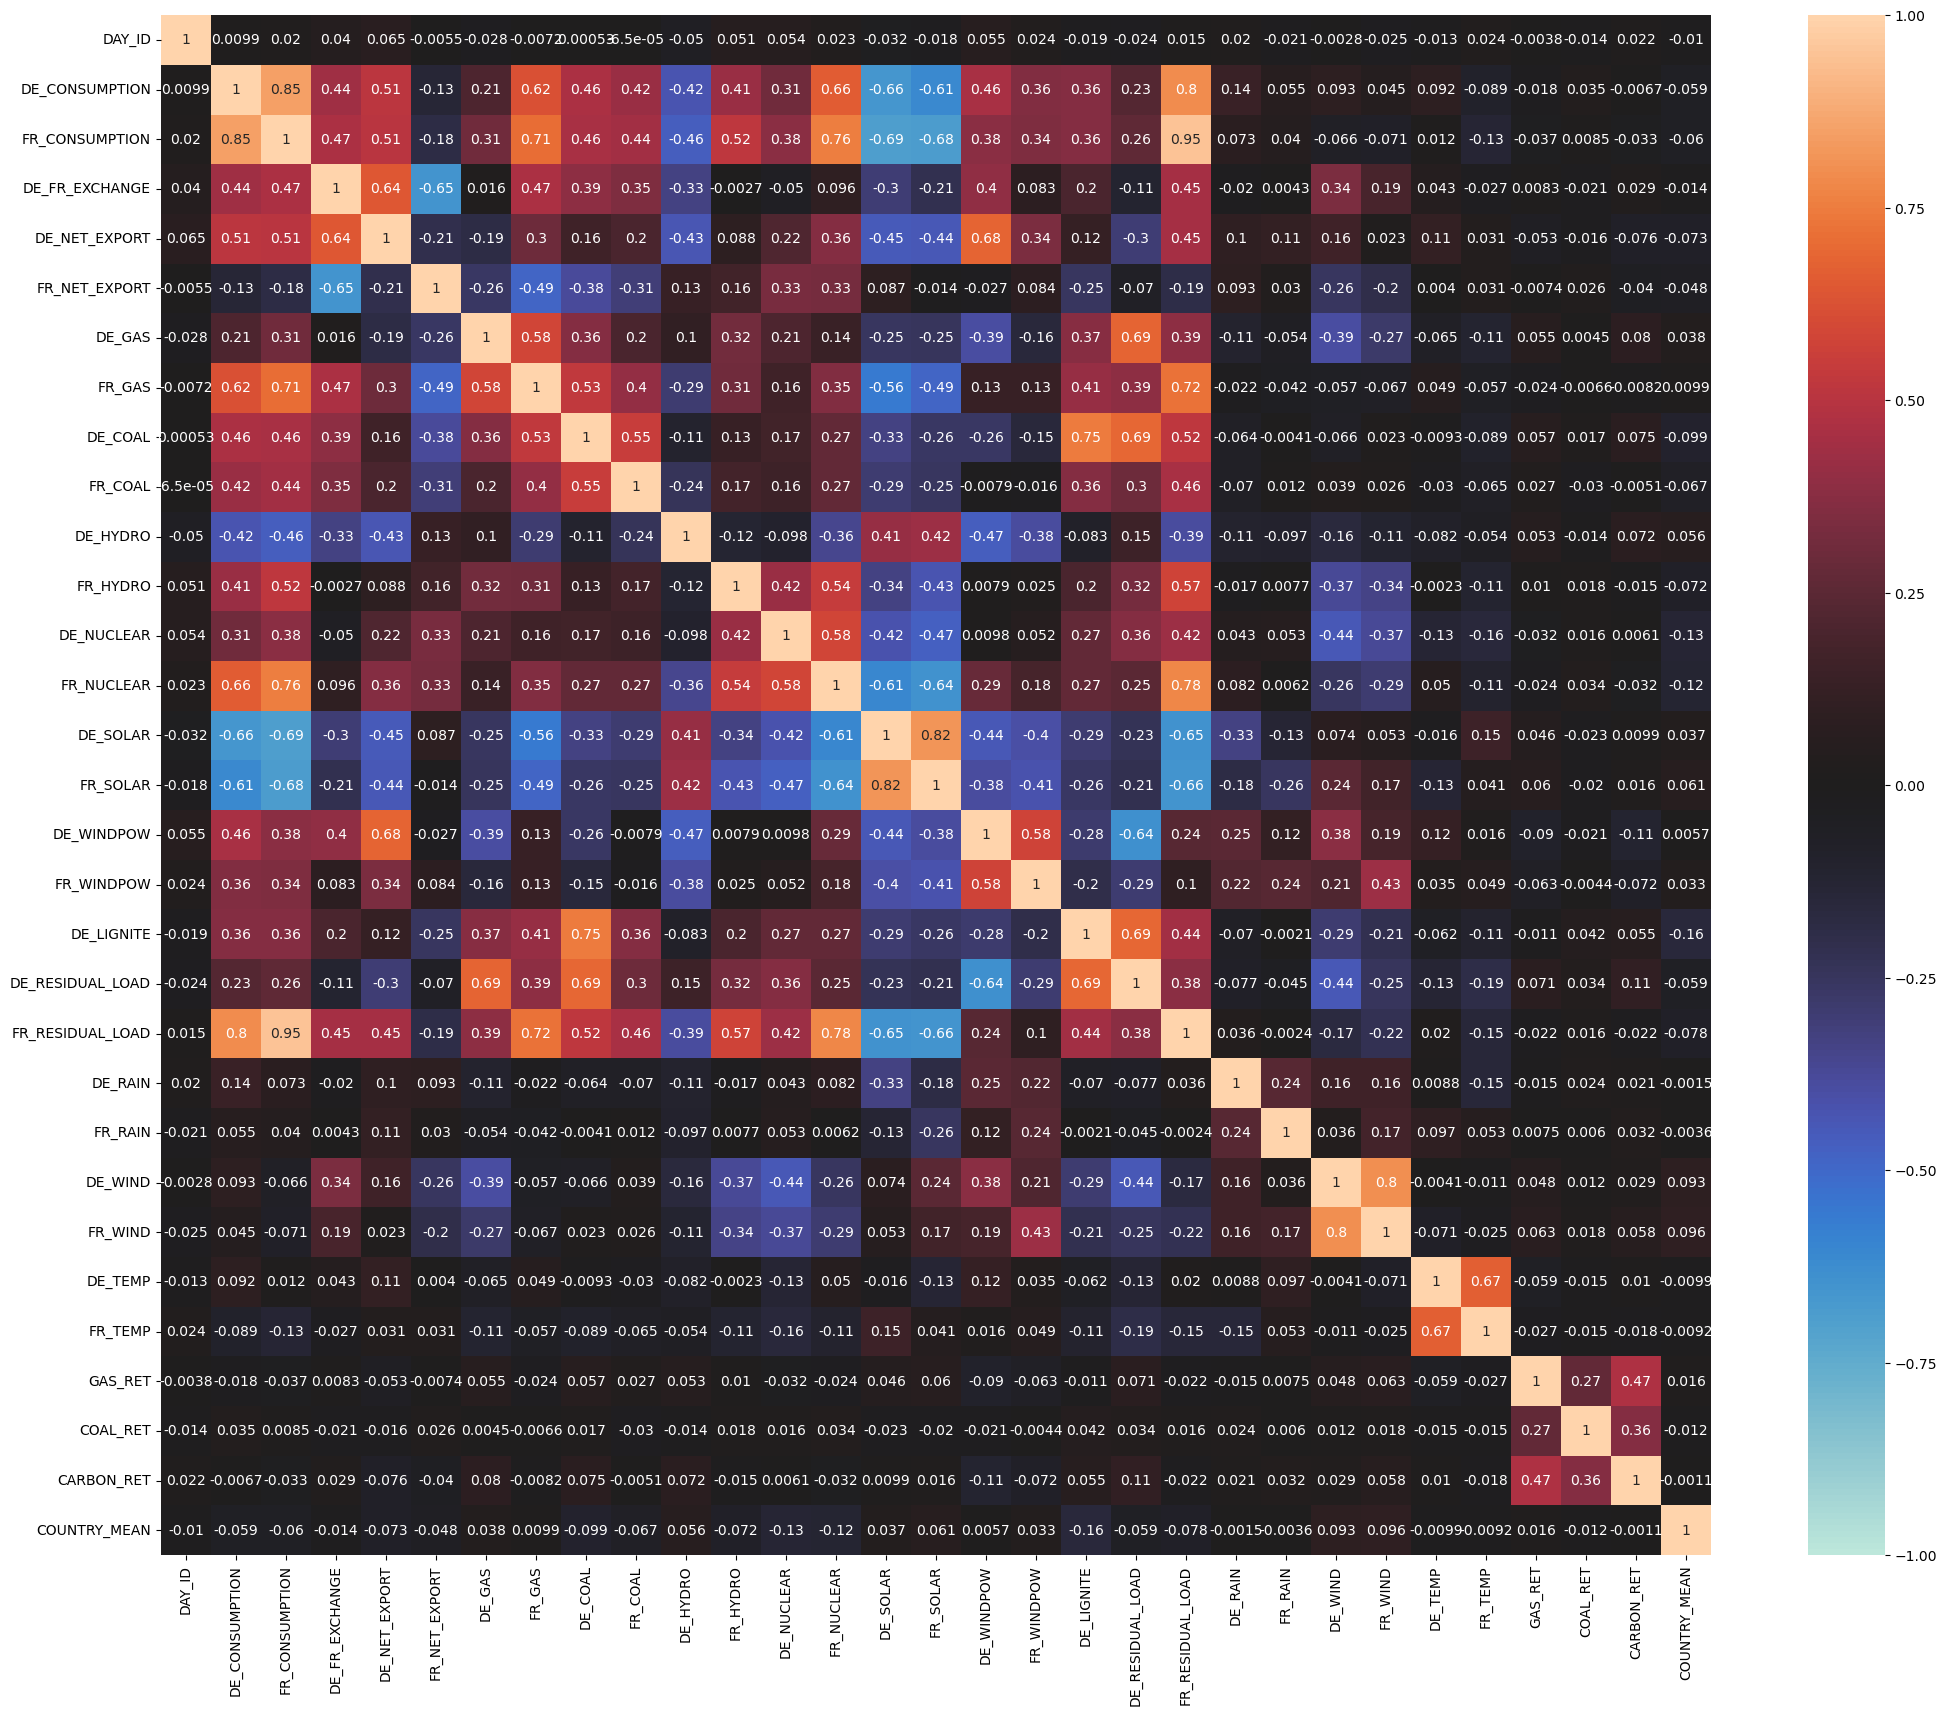

In [22]:
# plot heatmap of train and test data set after imputation
corr = X_train_test_filled[num_cols].corr(method=parameters['corr_method'])
print("Correlation matrix shape:", corr.shape)

plt.figure(figsize=[25,20])
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, center=0) 
plt.show()

In [23]:
# Top correlated pairs by |r|
pairs = []
cols = corr.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        r = corr.iloc[i, j]
        pairs.append((cols[i], cols[j], abs(r), r))
pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)[:20]
display(pd.DataFrame(pairs_sorted, columns=["feat1", "feat2", "|r|", "r"]))

feat1             feat2       |r|         r
0   FR_CONSUMPTION  FR_RESIDUAL_LOAD  0.948533  0.948533
1   DE_CONSUMPTION    FR_CONSUMPTION  0.850321  0.850321
2         DE_SOLAR          FR_SOLAR  0.815540  0.815540
3          DE_WIND           FR_WIND  0.802614  0.802614
4   DE_CONSUMPTION  FR_RESIDUAL_LOAD  0.796443  0.796443
5       FR_NUCLEAR  FR_RESIDUAL_LOAD  0.778629  0.778629
6   FR_CONSUMPTION        FR_NUCLEAR  0.757543  0.757543
7          DE_COAL        DE_LIGNITE  0.745513  0.745513
8           FR_GAS  FR_RESIDUAL_LOAD  0.720014  0.720014
9   FR_CONSUMPTION            FR_GAS  0.708716  0.708716
10         DE_COAL  DE_RESIDUAL_LOAD  0.691176  0.691176
11  FR_CONSUMPTION          DE_SOLAR  0.690325 -0.690325
12      DE_LIGNITE  DE_RESIDUAL_LOAD  0.689595  0.689595
13          DE_GAS  DE_RESIDUAL_LOAD  0.687199  0.687199
14  FR_CONSUMPTION          FR_SOLAR  0.683123 -0.683123
15   DE_NET_EXPORT        DE_WINDPOW  0.682868  0.682868
16         DE_TEMP           FR_TEMP  0.667540  0.667540
17  DE_CONSUMPTION        FR_NUCLEAR  0.662555  0.662555
18  DE_CONSUMPTION          DE_SOLAR  0.657111 -0.657111
19        FR_SOLAR  FR_RESIDUAL_LOAD  0.655051 -0.655051

## 4. Creating Features

### 4.1 Add residual columns according to high correlations

In [24]:
df_sorted_corr = pd.DataFrame(pairs_sorted, columns=["feat1", "feat2", "|r|", "r"])
df_top_corr = df_sorted_corr[df_sorted_corr["|r|"] > corr_threshold]
df_top_corr

feat1             feat2       |r|         r
0  FR_CONSUMPTION  FR_RESIDUAL_LOAD  0.948533  0.948533

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

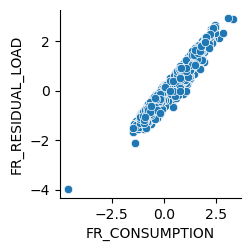

In [25]:
plt.clf()
plt.figure()
for idx, data in df_top_corr.iterrows():
    sns.pairplot(data=X_train_test_filled, x_vars=data.feat1, y_vars=data.feat2)
plt.show()

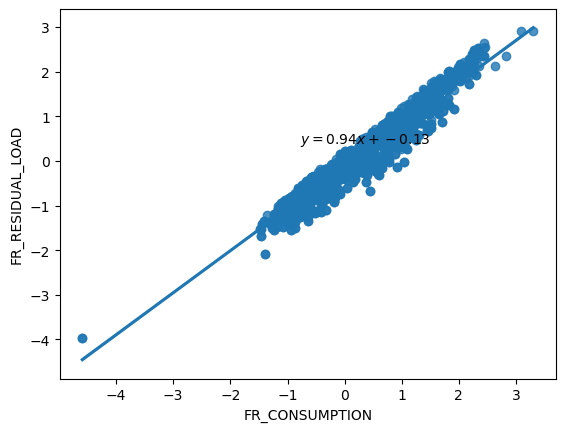

In [26]:
x_feature = df_top_corr.feat1.values[0]
y_feature = df_top_corr.feat2.values[0]

p = sns.regplot(x=x_feature, y=y_feature, data=X_train_test_filled)

#calculate slope and intercept of regression equation
slope, intercept, r, p, sterr = scipy.stats.linregress(x=p.get_lines()[0].get_xdata(),
                                                       y=p.get_lines()[0].get_ydata())

#add regression equation to plot
result_string = f"$y = {slope:.2f}x + {intercept:.2f}$"

plt.figtext(0.5, 0.6, result_string)
plt.show()

In [27]:
drop_features.append(y_feature)
if KeepOrigNumFeatures:
    drop_features = [x for x in drop_features if x not in orig_num_cols]
X_trte_engineered = X_train_test_filled.copy()
X_trte_engineered['RES_' + y_feature] = X_trte_engineered[y_feature] - (slope * X_trte_engineered[y_feature] + intercept)

### 4.2 Create features with golden combination characteristic

In [28]:
# create gold characteristics
for f in (de_features + fr_features + eu_features):
    if UseTimeSeries:
        f_mean_de = X_trte_engineered.loc[X_trte_engineered['COUNTRY'] == 'DE', f].mean()
        f_mean_fr = X_trte_engineered.loc[X_trte_engineered['COUNTRY'] == 'FR', f].mean()
        f_std_de = X_trte_engineered.loc[X_trte_engineered['COUNTRY'] == 'DE', f].std()
        f_std_fr = X_trte_engineered.loc[X_trte_engineered['COUNTRY'] == 'FR', f].std()
    else:
        df_temp = X_train[['ID']].merge(X_trte_engineered, on='ID', how='left')
        f_mean_de = df_temp.loc[df_temp['COUNTRY'] == 'DE', f].mean()
        f_mean_fr = df_temp.loc[df_temp['COUNTRY'] == 'FR', f].mean()
        f_std_de = df_temp.loc[df_temp['COUNTRY'] == 'DE', f].std()
        f_std_fr = df_temp.loc[df_temp['COUNTRY'] == 'FR', f].std()
        
    X_trte_engineered['GOLD_' + f] = X_trte_engineered.apply(lambda row: (row[f] - f_mean_de) / f_std_de if row.COUNTRY == 'DE' else (row[f] - f_mean_fr) / f_std_fr, axis=1)

### 4.3 Create features regarding target encoding

Group sum with target correlations as coefficient. There are five groups that need to be considered. They are EU commodity price variations, weather measures, electricity use metrics, renewable energy measures and non-renewable energy measures.

#### 4.3.1 Target encoding on EU commodity price variations

In [29]:
# target encoding
X_trte_engineered['TARENC_EU_RET'] = 0.0 
for f in eu_features:
    X_trte_engineered['TARENC_EU_RET'] += target_corr[f] * X_trte_engineered[f]

(2148, 66)

(1494, 67)

<Figure size 640x480 with 0 Axes>

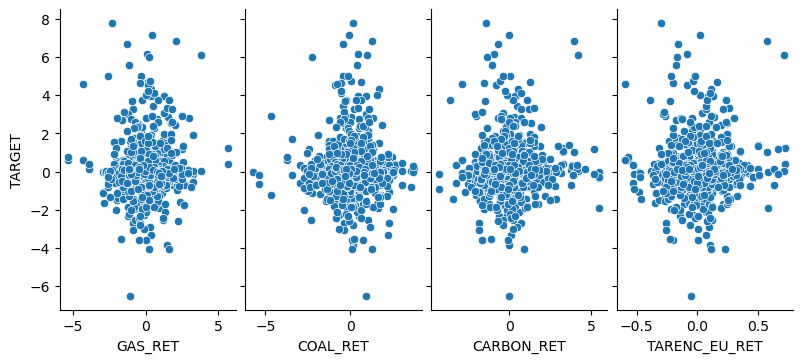

In [30]:
# plot features regarding EU commodity price variations
Xy_tr_engineered = pd.merge(X_trte_engineered, y_train, on='ID', how='right')
display(X_trte_engineered.shape)
display(Xy_tr_engineered.shape)

plt.clf()
diag = sns.pairplot(data=Xy_tr_engineered, x_vars=eu_features+['TARENC_EU_RET'], y_vars='TARGET')
diag.fig.set_size_inches(8, 4)
diag.set(xlim=(None, None))
plt.show()

#### 4.3.2 Target encoding on weather measures

In [31]:
# target encoding
X_trte_engineered['TARENC_WEATHER'] = 0.0 
for f in weather_features:
    X_trte_engineered['TARENC_WEATHER'] += target_corr[f] * X_trte_engineered[f]

(2148, 67)

(1494, 68)

<Figure size 640x480 with 0 Axes>

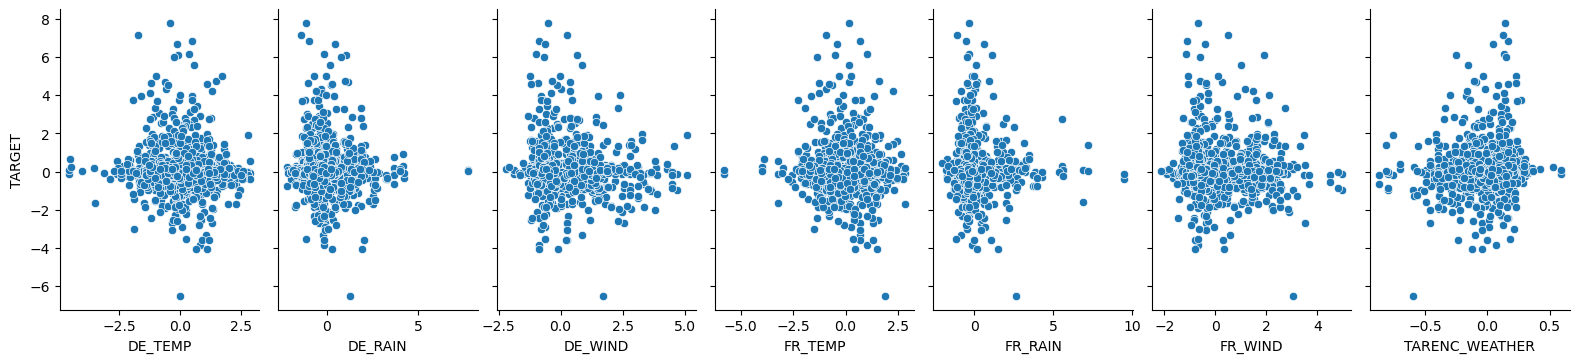

In [32]:
# plot features regarding weather measures
Xy_tr_engineered = pd.merge(X_trte_engineered, y_train, on='ID', how='right')
display(X_trte_engineered.shape)
display(Xy_tr_engineered.shape)

plt.clf()
diag = sns.pairplot(data=Xy_tr_engineered, x_vars=weather_features+['TARENC_WEATHER'], y_vars='TARGET')
diag.fig.set_size_inches(16, 4)
diag.set(xlim=(None, None))
plt.show()

#### 4.3.3 Target encoding on electricity use metrics

In [33]:
# target encoding
X_trte_engineered['TARENC_USE'] = 0.0 
for f in use_features:
    X_trte_engineered['TARENC_USE'] += target_corr[f] * X_trte_engineered[f]

(2148, 68)

(1494, 69)

<Figure size 640x480 with 0 Axes>

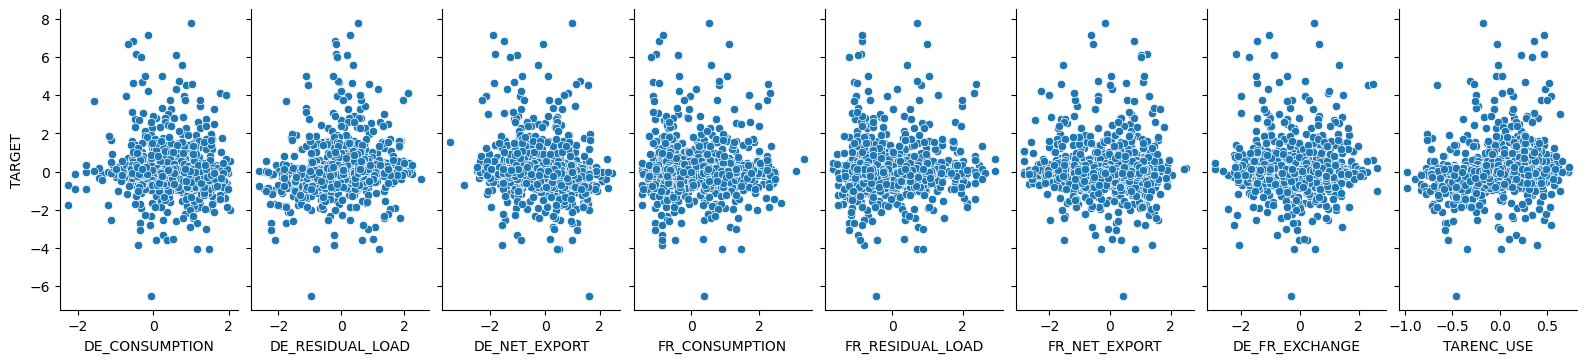

In [34]:
# plot features regarding electricity use metrics
Xy_tr_engineered = pd.merge(X_trte_engineered, y_train, on='ID', how='right')
display(X_trte_engineered.shape)
display(Xy_tr_engineered.shape)

plt.clf()
diag = sns.pairplot(data=Xy_tr_engineered, x_vars=use_features+['TARENC_USE'], y_vars='TARGET')
diag.fig.set_size_inches(16, 4)
diag.set(xlim=(None, None))
plt.show()

#### 4.3.4 Target encoding on renewable energy measures

In [35]:
# target encoding
X_trte_engineered['TARENC_RENEW'] = 0.0 
for f in renew_features:
    X_trte_engineered['TARENC_RENEW'] += target_corr[f] * X_trte_engineered[f]

(2148, 69)

(1494, 70)

<Figure size 640x480 with 0 Axes>

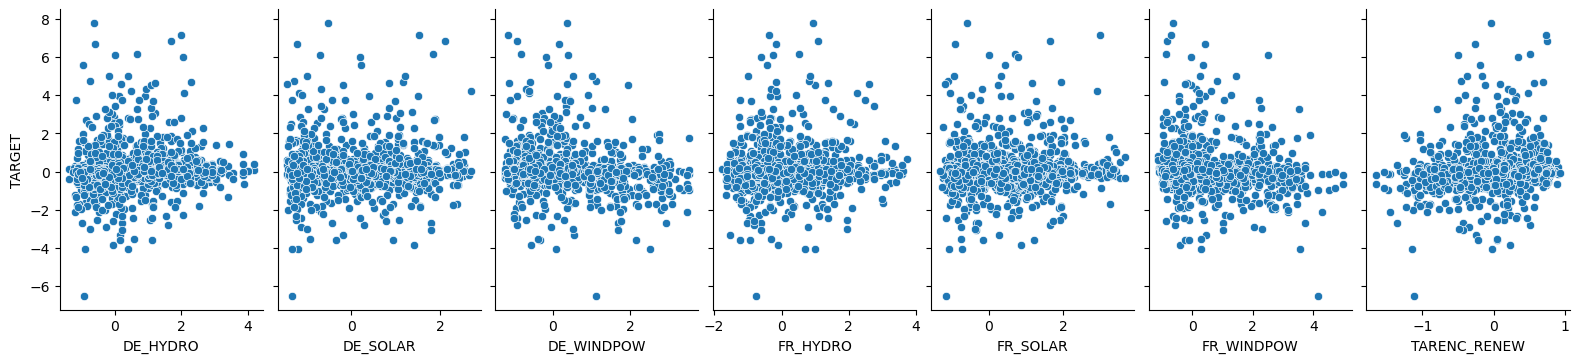

In [36]:
# plot features regarding renewable energy measures
Xy_tr_engineered = pd.merge(X_trte_engineered, y_train, on='ID', how='right')
display(X_trte_engineered.shape)
display(Xy_tr_engineered.shape)

plt.clf()
diag = sns.pairplot(data=Xy_tr_engineered, x_vars=renew_features+['TARENC_RENEW'], y_vars='TARGET')
diag.fig.set_size_inches(16, 4)
diag.set(xlim=(None, None))
plt.show()

#### 4.3.5 Target encoding on non-renewable energy measures

In [37]:
# target encoding
X_trte_engineered['TARENC_NONRENEW'] = 0.0 
for f in nonrenew_features:
    X_trte_engineered['TARENC_NONRENEW'] += target_corr[f] * X_trte_engineered[f]

(2148, 70)

(1494, 71)

<Figure size 640x480 with 0 Axes>

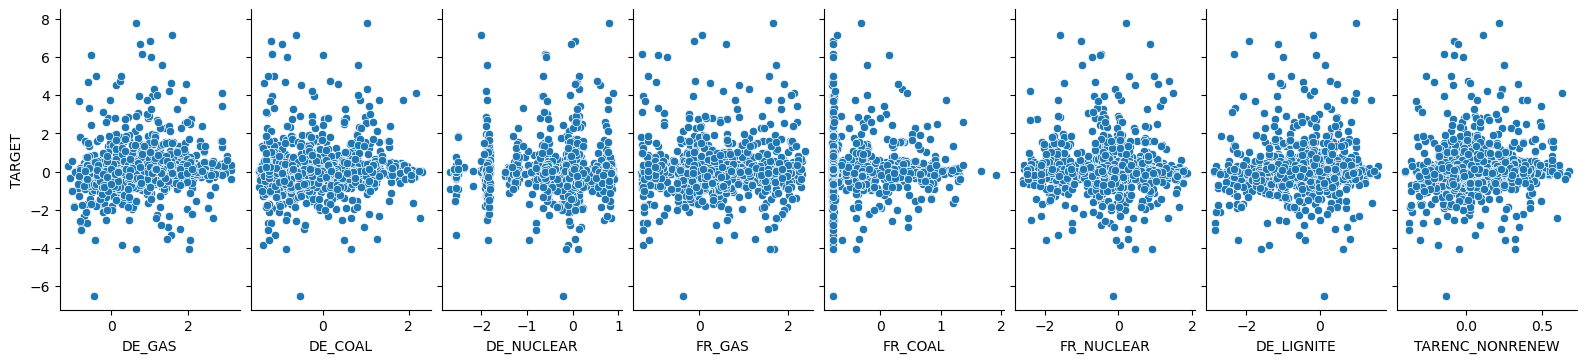

In [38]:
# plot features regarding non-renewable energy measures
Xy_tr_engineered = pd.merge(X_trte_engineered, y_train, on='ID', how='right')
display(X_trte_engineered.shape)
display(Xy_tr_engineered.shape)

plt.clf()
diag = sns.pairplot(data=Xy_tr_engineered, x_vars=nonrenew_features+['TARENC_NONRENEW'], y_vars='TARGET')
diag.fig.set_size_inches(16, 4)
diag.set(xlim=(None, None))
plt.show()

(2148, 71)

(1494, 72)

<Figure size 640x480 with 0 Axes>

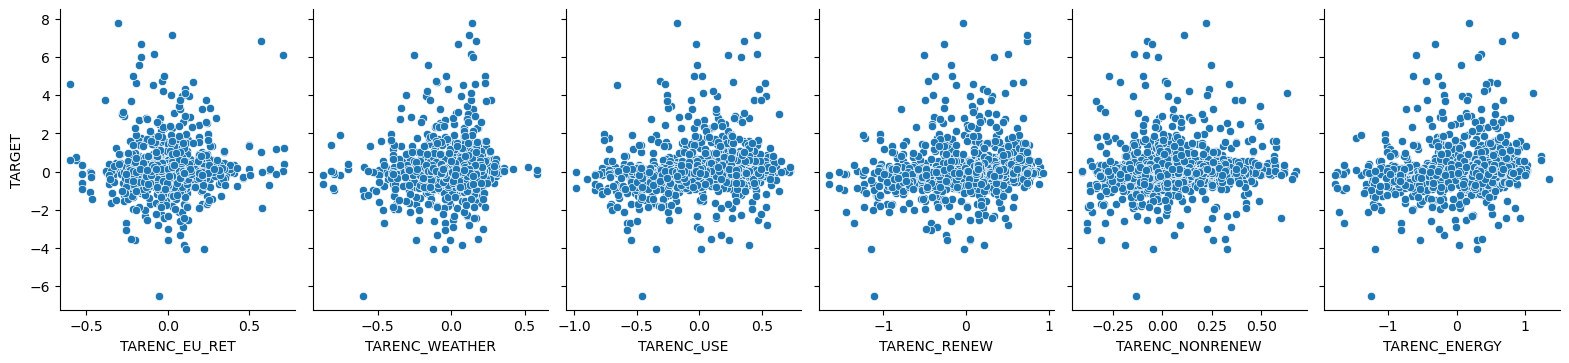

In [39]:
# plot all target encoding features
X_trte_engineered['TARENC_ENERGY'] = X_trte_engineered['TARENC_RENEW'] + X_trte_engineered['TARENC_NONRENEW']
Xy_tr_engineered = pd.merge(X_trte_engineered, y_train, on='ID', how='right')
display(X_trte_engineered.shape)
display(Xy_tr_engineered.shape)
target_encoding_list = [x for x in X_trte_engineered if 'TARENC_' in x]

plt.clf()
diag = sns.pairplot(data=Xy_tr_engineered, x_vars=target_encoding_list, y_vars='TARGET')
diag.fig.set_size_inches(16, 4)
diag.set(xlim=(None, None))
plt.show()

### 4.4 Add features based on 7-day-rolling

In [40]:
# check rolling duplicates
if UseTimeSeries:
    df_rolling = X_train_test_filled[num_cols[:-1]].copy()
    df_rolling.sort_values("DAY_ID", inplace=True)
    df_rolling.drop_duplicates(inplace=True)
    df_rolling[df_rolling.duplicated(subset=['DAY_ID'], keep=False)]

In [41]:
# carry out 7-day-rolling
if UseTimeSeries:
    for fea in num_cols[1:-1]: 
        if fea in df_rolling.columns:
            df_rolling[f"ROLL_{fea}"] = df_rolling[fea].rolling(7, min_periods=1).mean()
            df_rolling.drop(fea, axis=1, inplace=True)
    
    X_trte_engineered = pd.merge(X_trte_engineered, df_rolling, on='DAY_ID', how='left')

### 4.5 Create polynomial features for DE and FR data

In [42]:
# Split train and test data set by DE and FR 
X_trte_engineered_de = X_trte_engineered[X_trte_engineered['COUNTRY'] == 'DE']
X_trte_engineered_de.sort_values("DAY_ID", inplace=True)
X_trte_engineered_fr = X_trte_engineered[X_trte_engineered['COUNTRY'] == 'FR']
X_trte_engineered_fr.sort_values("DAY_ID", inplace=True)

y_train_de = Xy_tr_engineered.loc[Xy_tr_engineered['COUNTRY'] == 'DE', ['ID', 'TARGET']]
y_train_fr = Xy_tr_engineered.loc[Xy_tr_engineered['COUNTRY'] == 'FR', ['ID', 'TARGET']]

In [43]:
# polynomial features combined on DE and FR features
for fea in country_features:
    de = f"DE_{fea}"; fr = f"FR_{fea}"
    
    if de in X_trte_engineered_de.columns and fr in X_trte_engineered_de.columns:
        X_trte_engineered_de[f"DIFF_{fea}"] = X_trte_engineered_de[de] - X_trte_engineered_de[fr]
        X_trte_engineered_de[f"SUM_{fea}"] = X_trte_engineered_de[de] + X_trte_engineered_de[fr]

    if de in X_trte_engineered_fr.columns and fr in X_trte_engineered_fr.columns:
        X_trte_engineered_fr[f"DIFF_{fea}"] = X_trte_engineered_fr[fr] - X_trte_engineered_fr[de]
        X_trte_engineered_fr[f"SUM_{fea}"] = X_trte_engineered_fr[de] + X_trte_engineered_fr[fr]

In [44]:
# results obtained by merging DE and FR feature/target data and drop the 
X_trte_finished = pd.concat([X_trte_engineered_de, X_trte_engineered_fr], ignore_index=True).drop('COUNTRY', axis=1, inplace=False)

to_drop = [x for x in drop_features if x in X_trte_finished.columns]
if all(item in X_trte_finished.columns for item in to_drop):
    X_trte_finished.drop(to_drop, axis=1, inplace=True)  
    
Xy_tr_finished = pd.merge(X_trte_finished, y_train, on='ID', how='right')

## 5. Feature selection

### 5.1 Remove features with low mutual info and high target correlation

In [45]:
# mutual information ranking (top-k)
mi = mutual_info_regression(Xy_tr_finished.drop('TARGET', axis=1), Xy_tr_finished['TARGET'], random_state=RANDOM_STATE)
mi_series = pd.Series(mi, index=Xy_tr_finished.columns[:-1]).sort_values(ascending=False)
df_mi = mi_series.to_frame('MI')
df_mi_zero = df_mi[df_mi.MI <= 0.0]
display(df_mi_zero)

MI
DE_NET_EXPORT          0.0
FR_RESIDUAL_LOAD       0.0
DE_FR_EXCHANGE         0.0
GOLD_FR_RESIDUAL_LOAD  0.0
GOLD_FR_HYDRO          0.0
GOLD_FR_WIND           0.0
GOLD_DE_NET_EXPORT     0.0
GOLD_FR_COAL           0.0
GOLD_DE_COAL           0.0
RES_FR_RESIDUAL_LOAD   0.0
COAL_RET               0.0
GOLD_FR_NUCLEAR        0.0
GOLD_FR_WINDPOW        0.0
DIFF_RAIN              0.0
GOLD_COAL_RET          0.0
SUM_SOLAR              0.0
SUM_COAL               0.0

In [46]:
# high target correlations
assert "TARGET" in Xy_tr_finished.columns, "TARGET missing after merge"
target_corr = np.abs(Xy_tr_finished.corr(method=parameters['corr_method'])["TARGET"].drop("TARGET")).sort_values(ascending=False)
df_target_corr = target_corr.to_frame()
df_low_corr = df_target_corr[df_target_corr.TARGET <= target_corr_threshold]
display(df_low_corr)

TARGET
GOLD_DE_NUCLEAR     0.009531
DIFF_TEMP           0.009030
DE_NUCLEAR          0.007052
SUM_NUCLEAR         0.006183
DAY_ID              0.003901
FR_NUCLEAR          0.003619
GOLD_FR_NET_EXPORT  0.002950
FR_NET_EXPORT       0.002212
GOLD_FR_NUCLEAR     0.001109

In [47]:
# determine drop list according to low mutual info and high target correlation
mi_zero_or_low_corr = list(set(df_low_corr.index).union(set(df_mi_zero.index)))
display(mi_zero_or_low_corr)

['GOLD_DE_NET_EXPORT',
 'GOLD_FR_NET_EXPORT',
 'GOLD_FR_HYDRO',
 'DE_FR_EXCHANGE',
 'FR_NET_EXPORT',
 'SUM_NUCLEAR',
 'COAL_RET',
 'GOLD_FR_NUCLEAR',
 'GOLD_COAL_RET',
 'SUM_COAL',
 'GOLD_FR_WIND',
 'GOLD_FR_COAL',
 'GOLD_FR_WINDPOW',
 'FR_NUCLEAR',
 'GOLD_DE_COAL',
 'GOLD_DE_NUCLEAR',
 'DE_NET_EXPORT',
 'DIFF_TEMP',
 'GOLD_FR_RESIDUAL_LOAD',
 'DIFF_RAIN',
 'RES_FR_RESIDUAL_LOAD',
 'SUM_SOLAR',
 'FR_RESIDUAL_LOAD',
 'DAY_ID',
 'DE_NUCLEAR']

In [48]:
# remove the selected features
drop_features += mi_zero_or_low_corr
if KeepOrigNumFeatures:
    drop_features = [x for x in drop_features if x not in orig_num_cols]

to_drop = [x for x in drop_features if x in X_trte_finished.columns]
if all(item in X_trte_finished.columns for item in to_drop):
    X_trte_finished.drop(to_drop, axis=1, inplace=True)  
    
Xy_tr_finished = pd.merge(X_trte_finished, y_train, on='ID', how='right')

### 5.2 Processing selection of highly correlated features

Correlation matrix shape: (73, 73)


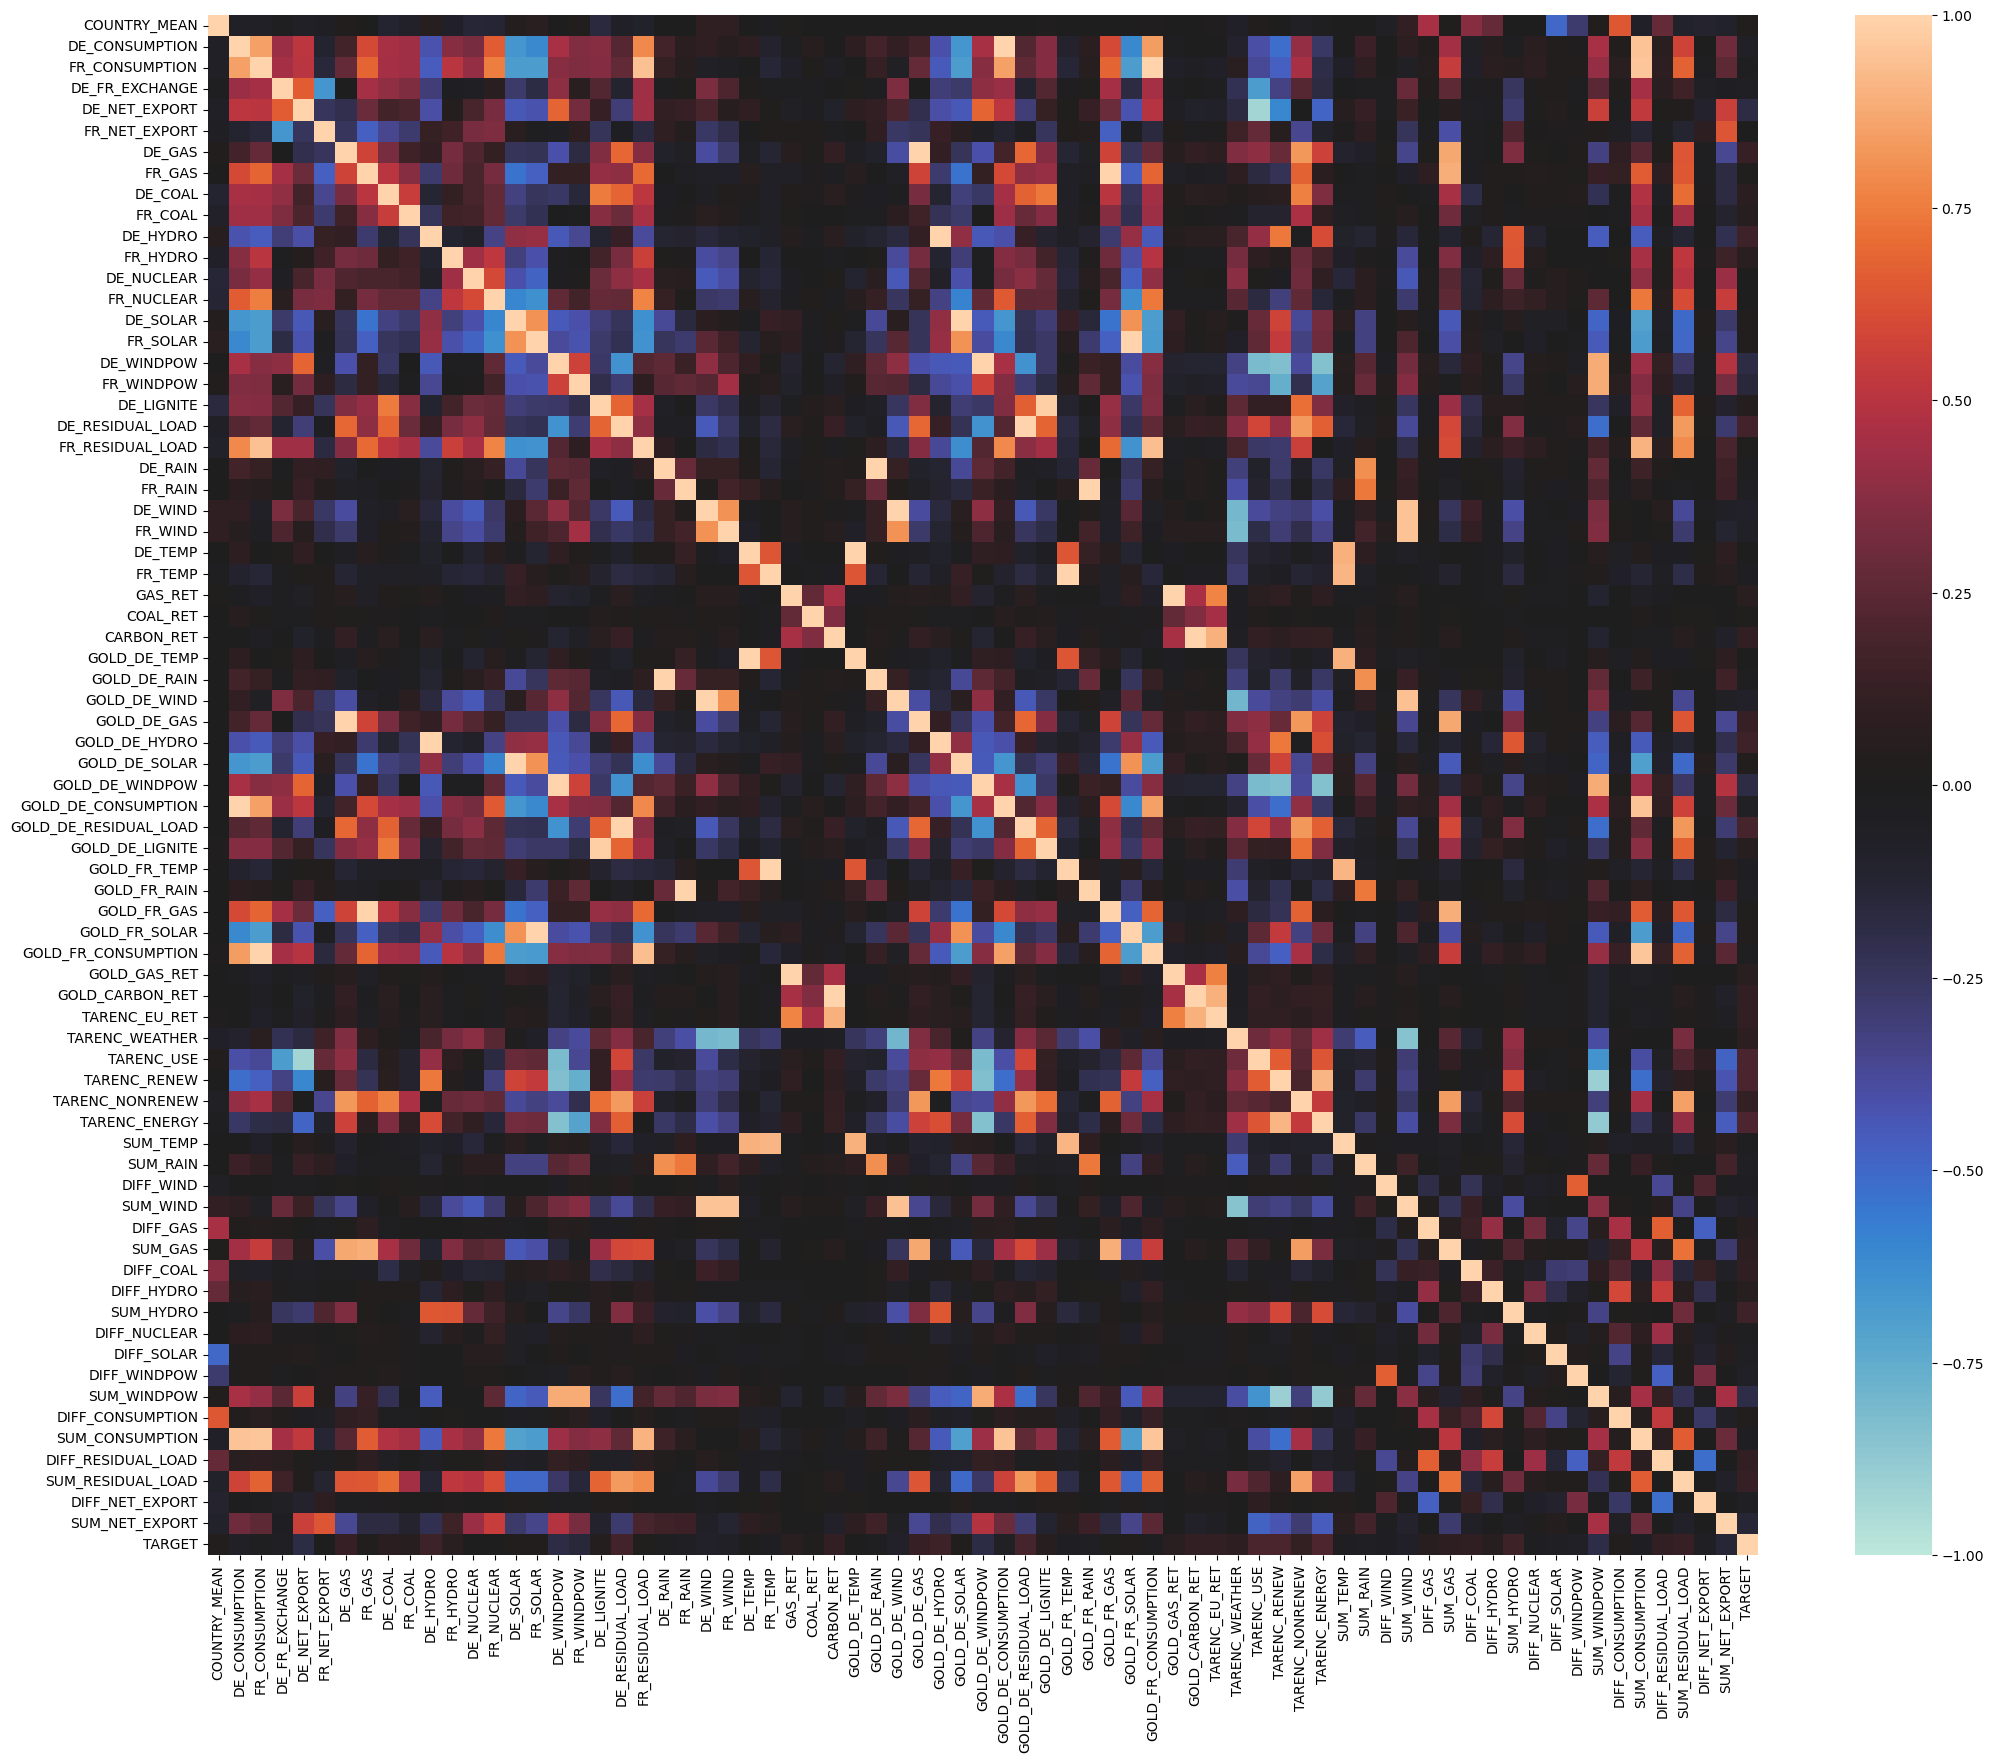

In [49]:
# plot heatmap of train data with target after feature creating
if not UseTimeSeries:
    corr = Xy_tr_finished.drop('ID', axis=1).corr(method=parameters['corr_method'])
    print("Correlation matrix shape:", corr.shape)
    
    plt.figure(figsize=[25,20])
    sns.heatmap(corr, annot=False, vmin=-1, vmax=1, center=0) 
    plt.show()

In [50]:
# plot heatmap of train and test data after feature creating
if UseTimeSeries:
    corr = X_trte_finished.drop('ID', axis=1).corr(method=parameters['corr_method'])
    print("Correlation matrix shape:", corr.shape)
    
    plt.figure(figsize=[25,20])
    sns.heatmap(corr, annot=False, vmin=-1, vmax=1, center=0) 
    plt.show()

In [51]:
# top correlated pairs by |r|
pairs = []
cols = corr.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        r = corr.iloc[i, j]
        pairs.append((cols[i], cols[j], abs(r), r))
pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)[:60]
pd_pairs_corr = pd.DataFrame(pairs_sorted, columns=["feat1", "feat2", "|r|", "r"])
pd_pairs_high_corr = pd_pairs_corr[pd_pairs_corr['|r|'] >= corr_threshold]
display(pd_pairs_high_corr)

feat1                  feat2       |r|         r
0            DE_WINDPOW        GOLD_DE_WINDPOW  0.999968  0.999968
1            CARBON_RET        GOLD_CARBON_RET  0.999951  0.999951
2               DE_RAIN           GOLD_DE_RAIN  0.999950  0.999950
3               FR_TEMP           GOLD_FR_TEMP  0.999940  0.999940
4                FR_GAS            GOLD_FR_GAS  0.999828  0.999828
5               DE_TEMP           GOLD_DE_TEMP  0.999791  0.999791
6               GAS_RET           GOLD_GAS_RET  0.999723  0.999723
7               FR_RAIN           GOLD_FR_RAIN  0.999716  0.999716
8                DE_GAS            GOLD_DE_GAS  0.999359  0.999359
9              DE_SOLAR          GOLD_DE_SOLAR  0.998920  0.998920
10             DE_HYDRO          GOLD_DE_HYDRO  0.998081  0.998081
11       DE_CONSUMPTION    GOLD_DE_CONSUMPTION  0.997565  0.997565
12             FR_SOLAR          GOLD_FR_SOLAR  0.997557  0.997557
13     DE_RESIDUAL_LOAD  GOLD_DE_RESIDUAL_LOAD  0.997431  0.997431
14       FR_CONSUMPTION    GOLD_FR_CONSUMPTION  0.995941  0.995941
15              DE_WIND           GOLD_DE_WIND  0.993400  0.993400
16           DE_LIGNITE        GOLD_DE_LIGNITE  0.981081  0.981081
17       FR_CONSUMPTION        SUM_CONSUMPTION  0.959291  0.959291
18  GOLD_FR_CONSUMPTION        SUM_CONSUMPTION  0.955112  0.955112
19       DE_CONSUMPTION        SUM_CONSUMPTION  0.952950  0.952950
20              FR_WIND               SUM_WIND  0.951897  0.951897
21  GOLD_DE_CONSUMPTION        SUM_CONSUMPTION  0.950420  0.950420
22              DE_WIND               SUM_WIND  0.946841  0.946841
23       FR_CONSUMPTION       FR_RESIDUAL_LOAD  0.941636  0.941636
24         GOLD_DE_WIND               SUM_WIND  0.939552  0.939552
25     FR_RESIDUAL_LOAD    GOLD_FR_CONSUMPTION  0.935795  0.935795
26        DE_NET_EXPORT             TARENC_USE  0.925902 -0.925902
27         TARENC_RENEW          TARENC_ENERGY  0.913896  0.913896
28              FR_TEMP               SUM_TEMP  0.906696  0.906696
29         GOLD_FR_TEMP               SUM_TEMP  0.906653  0.906653
30         TARENC_RENEW            SUM_WINDPOW  0.904811 -0.904811
31     FR_RESIDUAL_LOAD        SUM_CONSUMPTION  0.900091  0.900091

In [52]:
# determine drop list according to highly correlated features
drop_pairs = []

for idx, data in pd_pairs_high_corr.iterrows():
    drop_fea = ''

    if (data.feat1 not in drop_pairs) and (data.feat2 not in drop_pairs):
        if (data.feat1 not in num_cols) and (data.feat2 in num_cols):
            drop_fea = data.feat1
        elif (data.feat1 in num_cols) and (data.feat2 not in num_cols):
            drop_fea = data.feat2
        elif (data.feat1 not in num_cols) and (data.feat2 not in num_cols):
            if target_corr[data.feat1] < target_corr[data.feat2]:
                drop_fea = data.feat1
            elif target_corr[data.feat1] > target_corr[data.feat2]:
                drop_fea = data.feat2
            elif mi_series[data.feat1] < mi_series[data.feat2]:
                drop_fea = data.feat1
            else:
                drop_fea = data.feat2

    if drop_fea != '':
        drop_pairs.append(drop_fea)

display(drop_pairs)

['GOLD_DE_WINDPOW',
 'GOLD_CARBON_RET',
 'GOLD_DE_RAIN',
 'GOLD_FR_TEMP',
 'GOLD_FR_GAS',
 'GOLD_DE_TEMP',
 'GOLD_GAS_RET',
 'GOLD_FR_RAIN',
 'GOLD_DE_GAS',
 'GOLD_DE_SOLAR',
 'GOLD_DE_HYDRO',
 'GOLD_DE_CONSUMPTION',
 'GOLD_FR_SOLAR',
 'GOLD_DE_RESIDUAL_LOAD',
 'GOLD_FR_CONSUMPTION',
 'GOLD_DE_WIND',
 'GOLD_DE_LIGNITE',
 'SUM_CONSUMPTION',
 'SUM_WIND',
 'TARENC_USE',
 'TARENC_RENEW',
 'SUM_TEMP']

In [53]:
# remove the selected features
drop_features += drop_pairs
if KeepOrigNumFeatures:
    drop_features = [x for x in drop_features if x not in orig_num_cols]

to_drop = [x for x in drop_features if x in X_trte_finished.columns]
if all(item in X_trte_finished.columns for item in to_drop):
    X_trte_finished.drop(to_drop, axis=1, inplace=True)  
    
Xy_tr_finished = pd.merge(X_trte_finished, y_train, on='ID', how='right')

Correlation matrix shape: (51, 51)


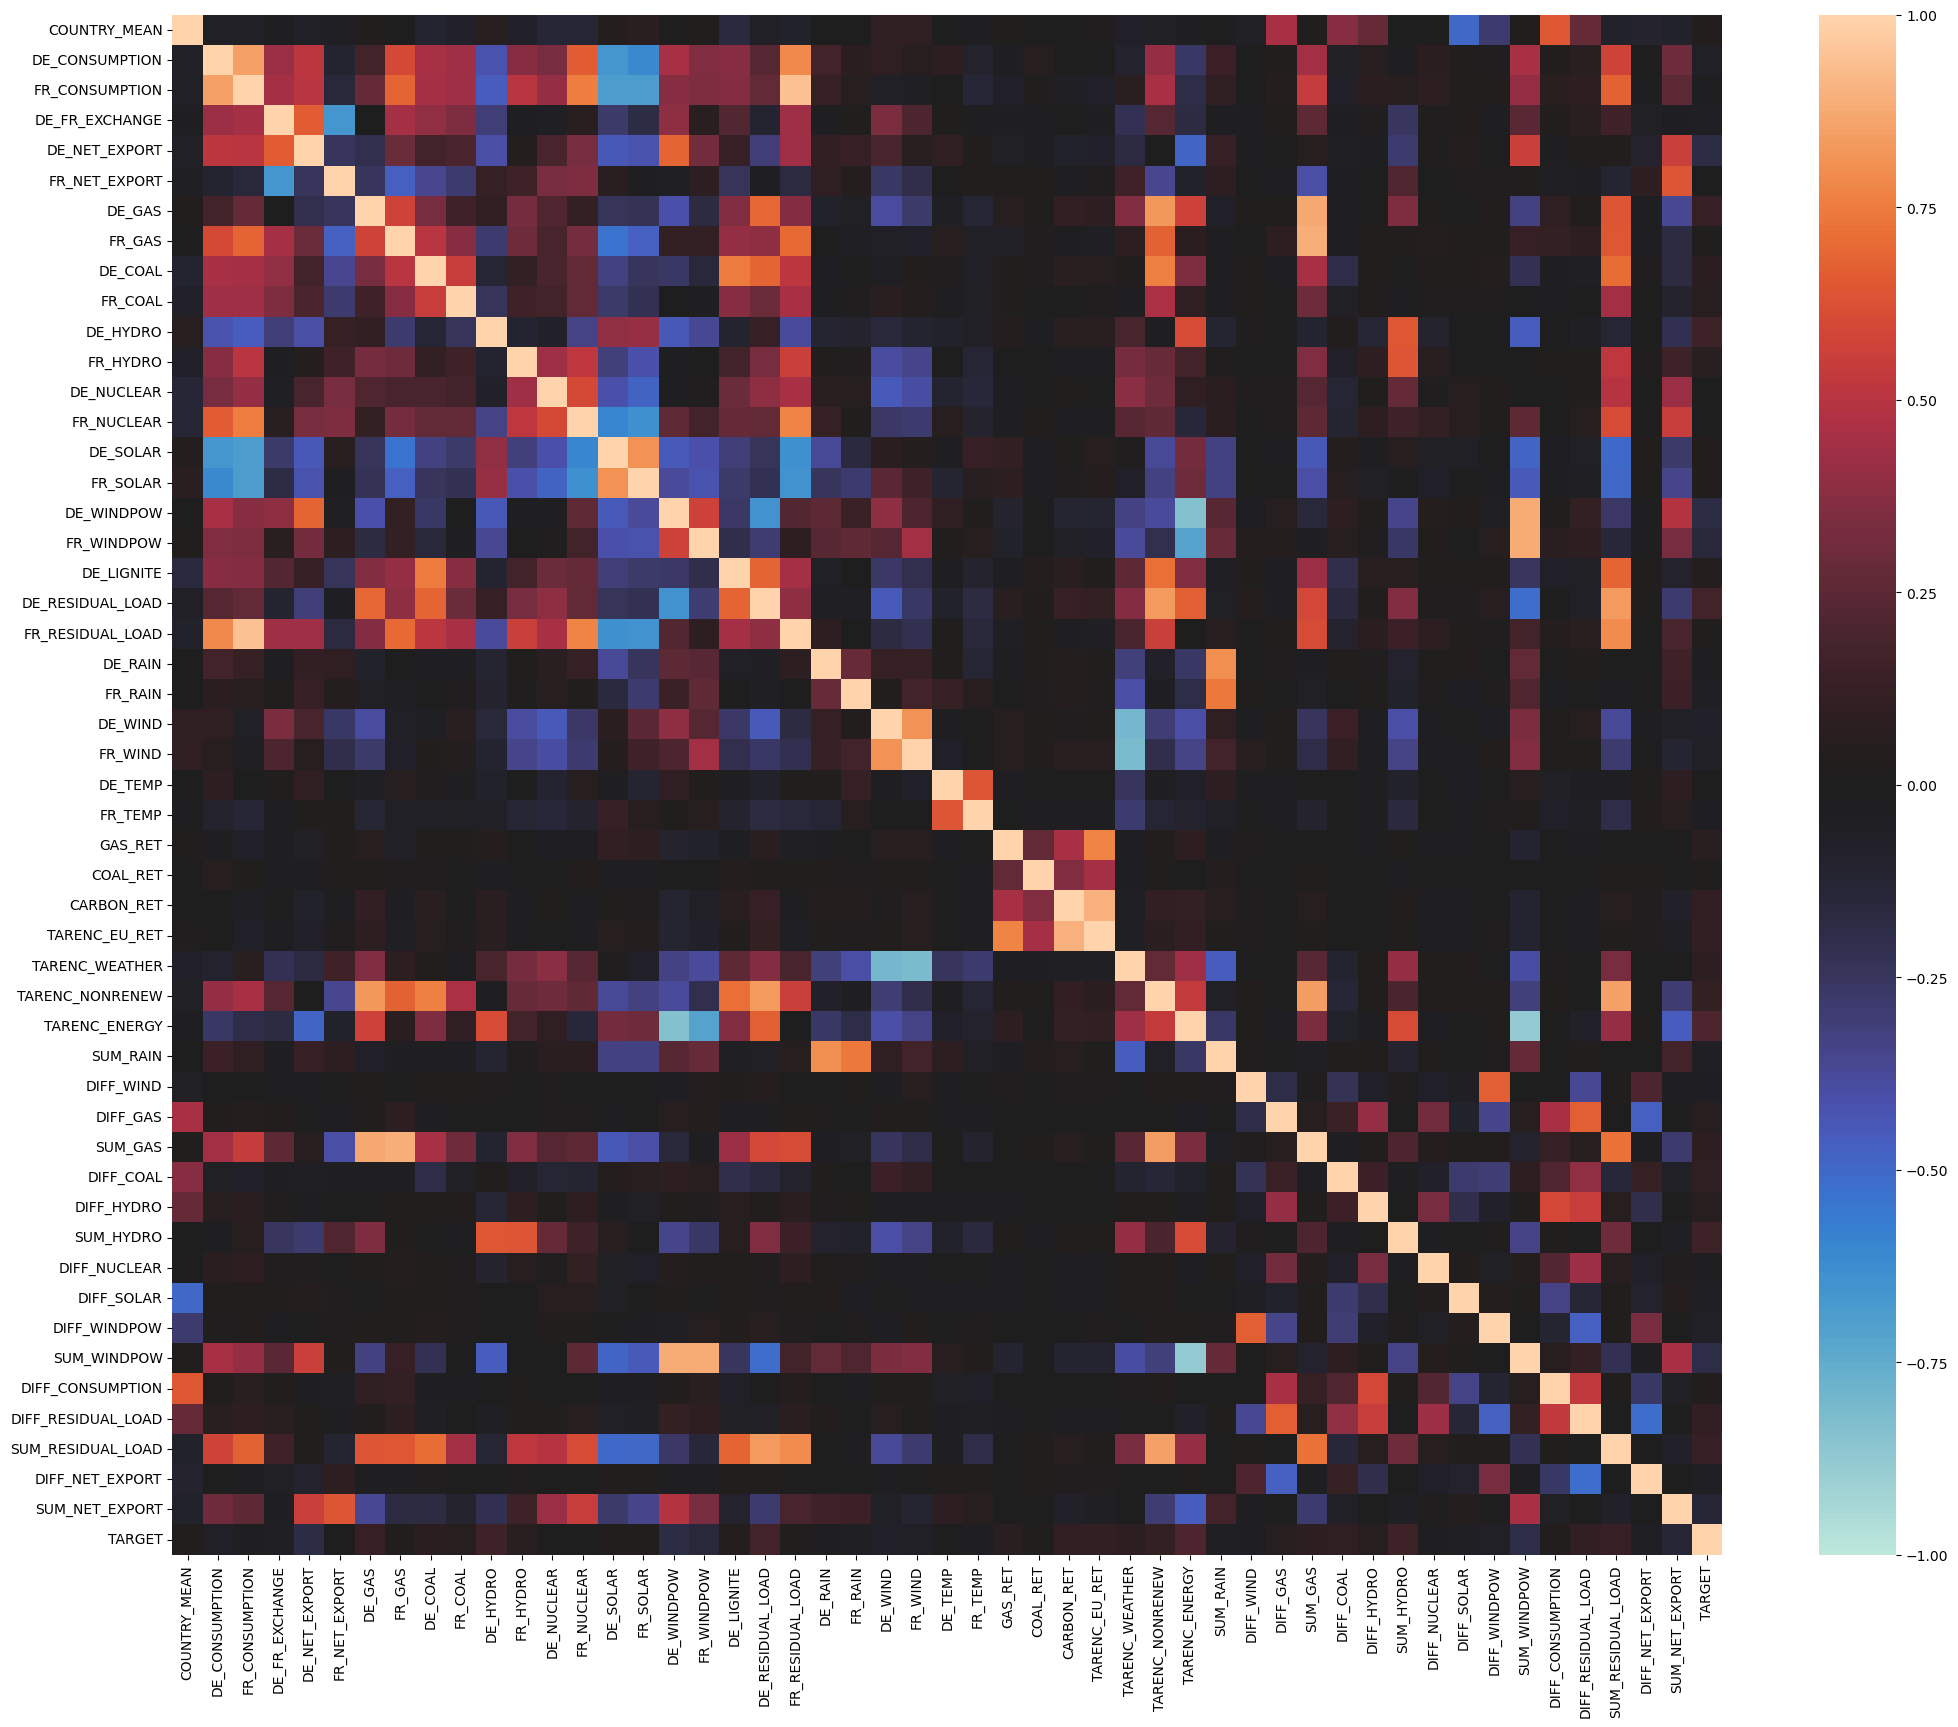

In [54]:
# plot heatmap of train data with target
if not UseTimeSeries:
    corr = Xy_tr_finished.drop('ID', axis=1).corr(method=parameters['corr_method'])
    print("Correlation matrix shape:", corr.shape)
    
    plt.figure(figsize=[25,20])
    sns.heatmap(corr, annot=False, vmin=-1, vmax=1, center=0) 
    plt.show()

In [55]:
# plot heatmap of train and test data after feature creating
if UseTimeSeries:
    corr = X_trte_finished.drop('ID', axis=1).corr(method=parameters['corr_method'])
    print("Correlation matrix shape:", corr.shape)
    
    plt.figure(figsize=[25,20])
    sns.heatmap(corr, annot=False, vmin=-1, vmax=1, center=0) 
    plt.show()

In [56]:
# check if there are still highly correlated pairs
pairs = []
cols = corr.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        r = corr.iloc[i, j]
        pairs.append((cols[i], cols[j], abs(r), r))
pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)[:60]
pd_pairs_corr = pd.DataFrame(pairs_sorted, columns=["feat1", "feat2", "|r|", "r"])
pd_pairs_high_corr = pd_pairs_corr[pd_pairs_corr['|r|'] >= corr_threshold]
print(f"there are {len(pd_pairs_high_corr)} highly correlated pairs.") 

there are 1 highly correlated pairs.


### 5.3 Selection according to feature outliers

In [57]:
# count the columns with a large number of missing and outlier values
c_outlier = column_missing_and_outliers(Xy_tr_finished)
drop_c_outlier = list(c_outlier.loc[(c_outlier.n_missing + c_outlier.n_outliers) > missing_outlier_c_threshold].index)
print(f"The number of columns with a large count of outlier values is {len(drop_c_outlier)}")
if 'TARGET' in drop_c_outlier:
    drop_c_outlier.remove('TARGET')
drop_columns += drop_c_outlier
drop_columns = list(set(drop_columns))
display(drop_columns)

The number of columns with a large count of outlier values is 1


['FR_COAL']

In [58]:
# remove the columns with a large number of missing and outlier values
display((X_train.shape, X_test.shape, X_trte_finished.shape, Xy_tr_finished.shape))
drop_columns_large = [x for x in drop_columns if x in X_trte_finished.columns]
drop_columns_small = [x for x in drop_columns if x in X_train.columns]

if RemoveMissingOutlier and len(drop_columns_small) > 0:
    X_train = X_train.drop(drop_columns_small, axis=1)
    X_test = X_test.drop(drop_columns_small, axis=1)

if RemoveMissingOutlier and len(drop_columns_large) > 0:
    X_trte_finished = X_trte_finished.drop(drop_columns_large, axis=1)
    Xy_tr_finished = Xy_tr_finished.drop(drop_columns_large, axis=1)
    num_cols = [x for x in num_cols if x not in drop_columns]

display((X_train.shape, X_test.shape, X_trte_finished.shape, Xy_tr_finished.shape))

((1494, 35), (654, 32), (2148, 51), (1494, 52))

((1494, 35), (654, 32), (2148, 51), (1494, 52))

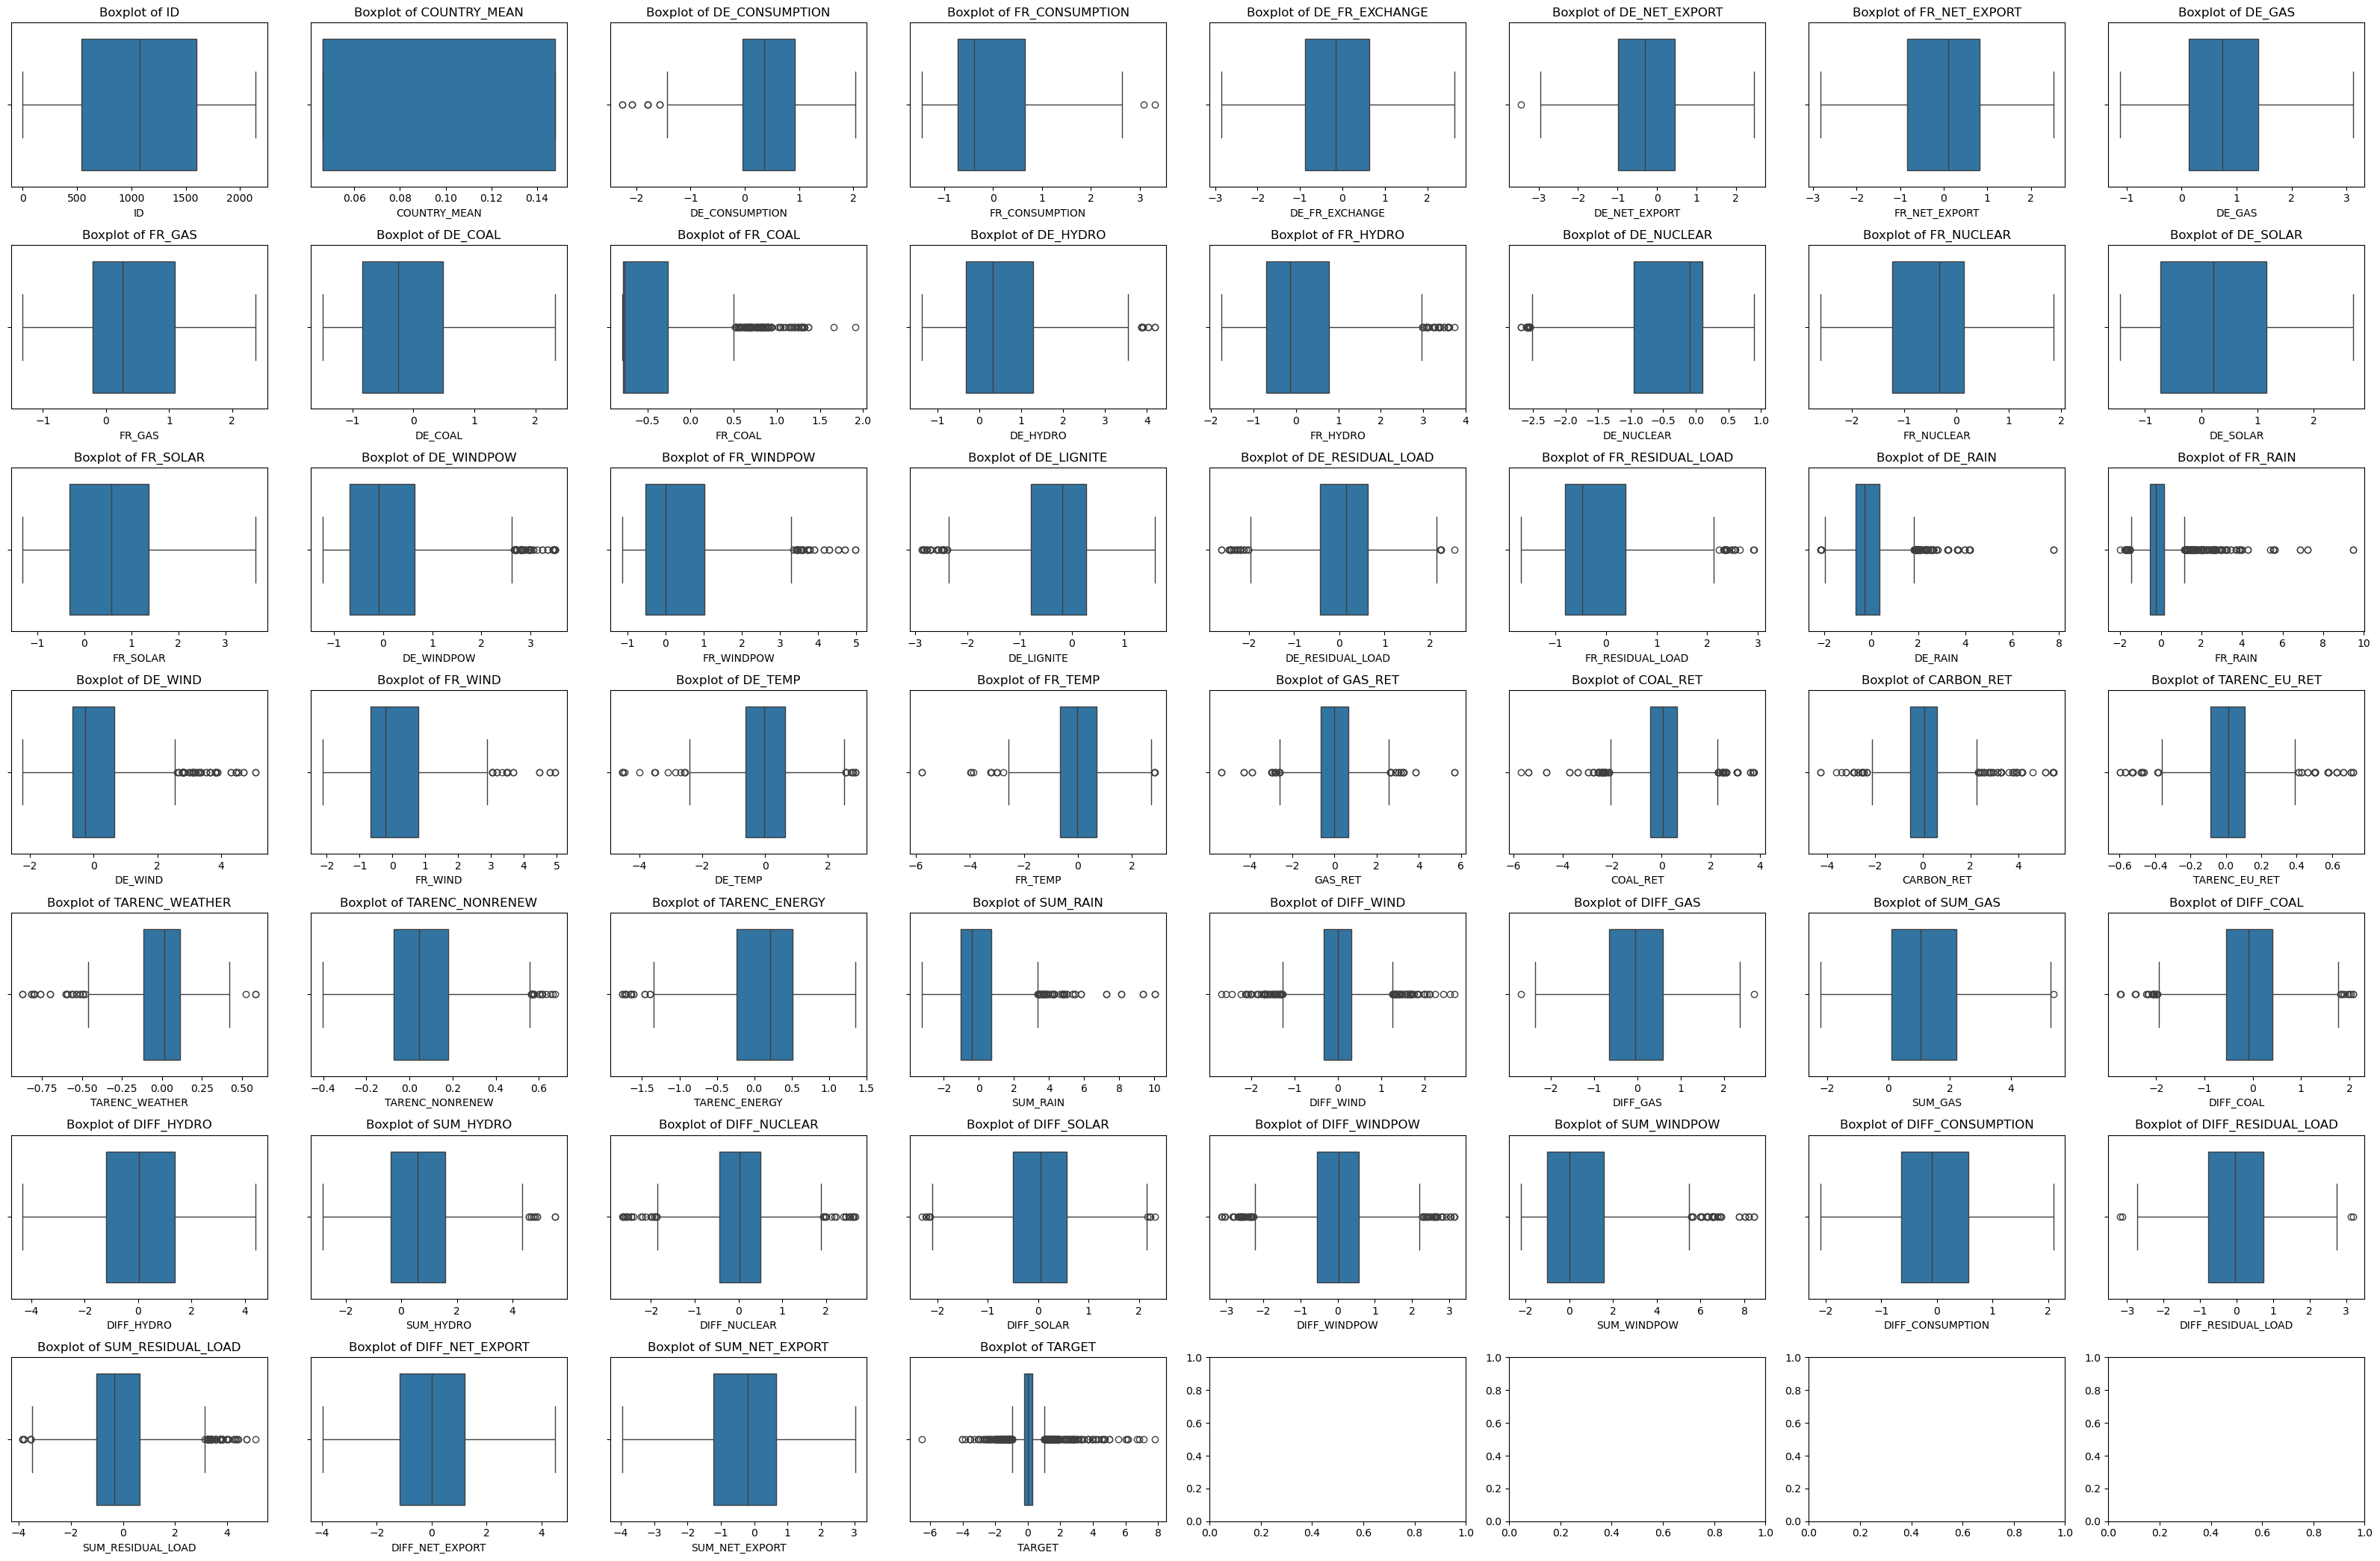

In [59]:
# plot the outliers for each feature
plots = [(c, Xy_tr_finished[c]) for c in Xy_tr_finished.columns]

K = len(plots)
N = math.ceil(math.sqrt(K))            
M = math.ceil(K / N)                 

fig, axes = plt.subplots(M, N, figsize=(N*4, M*3), squeeze=False)
axes = axes.ravel()

for i, (name, s) in enumerate(plots):
    sns.boxplot(x=s, ax=axes[i])
    axes[i].set_title(f"Boxplot of {name}")

plt.tight_layout()
plt.show()

### 5.4 Furture selection with null importance

Feature selection process using target permutation tests actual importance significance against the distribution of feature importances when fitted to noise. 

In [60]:
# create scoring function
def get_feature_importances(data, shuffle, seed=None):
    # Gather real features
    train_features = [f for f in data if f not in ['TARGET']]
    # Go over fold and keep track of CV score (train and valid) and feature importances

    # Shuffle target if required
    y = data['TARGET'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['TARGET'].copy().sample(frac=1.0)

        # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'rf',
        'subsample': 0.623,
        'colsample_bytree': 0.7,
        'num_leaves': 127,
        'max_depth': 8,
        'seed': seed,
        'bagging_freq': 1,
        'verbose': -1,
        'n_jobs': 4
    }

    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = mean_squared_error(y, clf.predict(data[train_features]))

    return imp_df

In [61]:
# build the benchmark for feature importance
data = Xy_tr_finished
actual_imp_df = get_feature_importances(data=data, shuffle=False)

null_imp_df = pd.DataFrame()
nb_runs = 80
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=data, shuffle=True)
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)

In [62]:
# compute importance scores
feature_scores = []

for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])
scores_df = scores_df.sort_values('split_score', ascending=False)

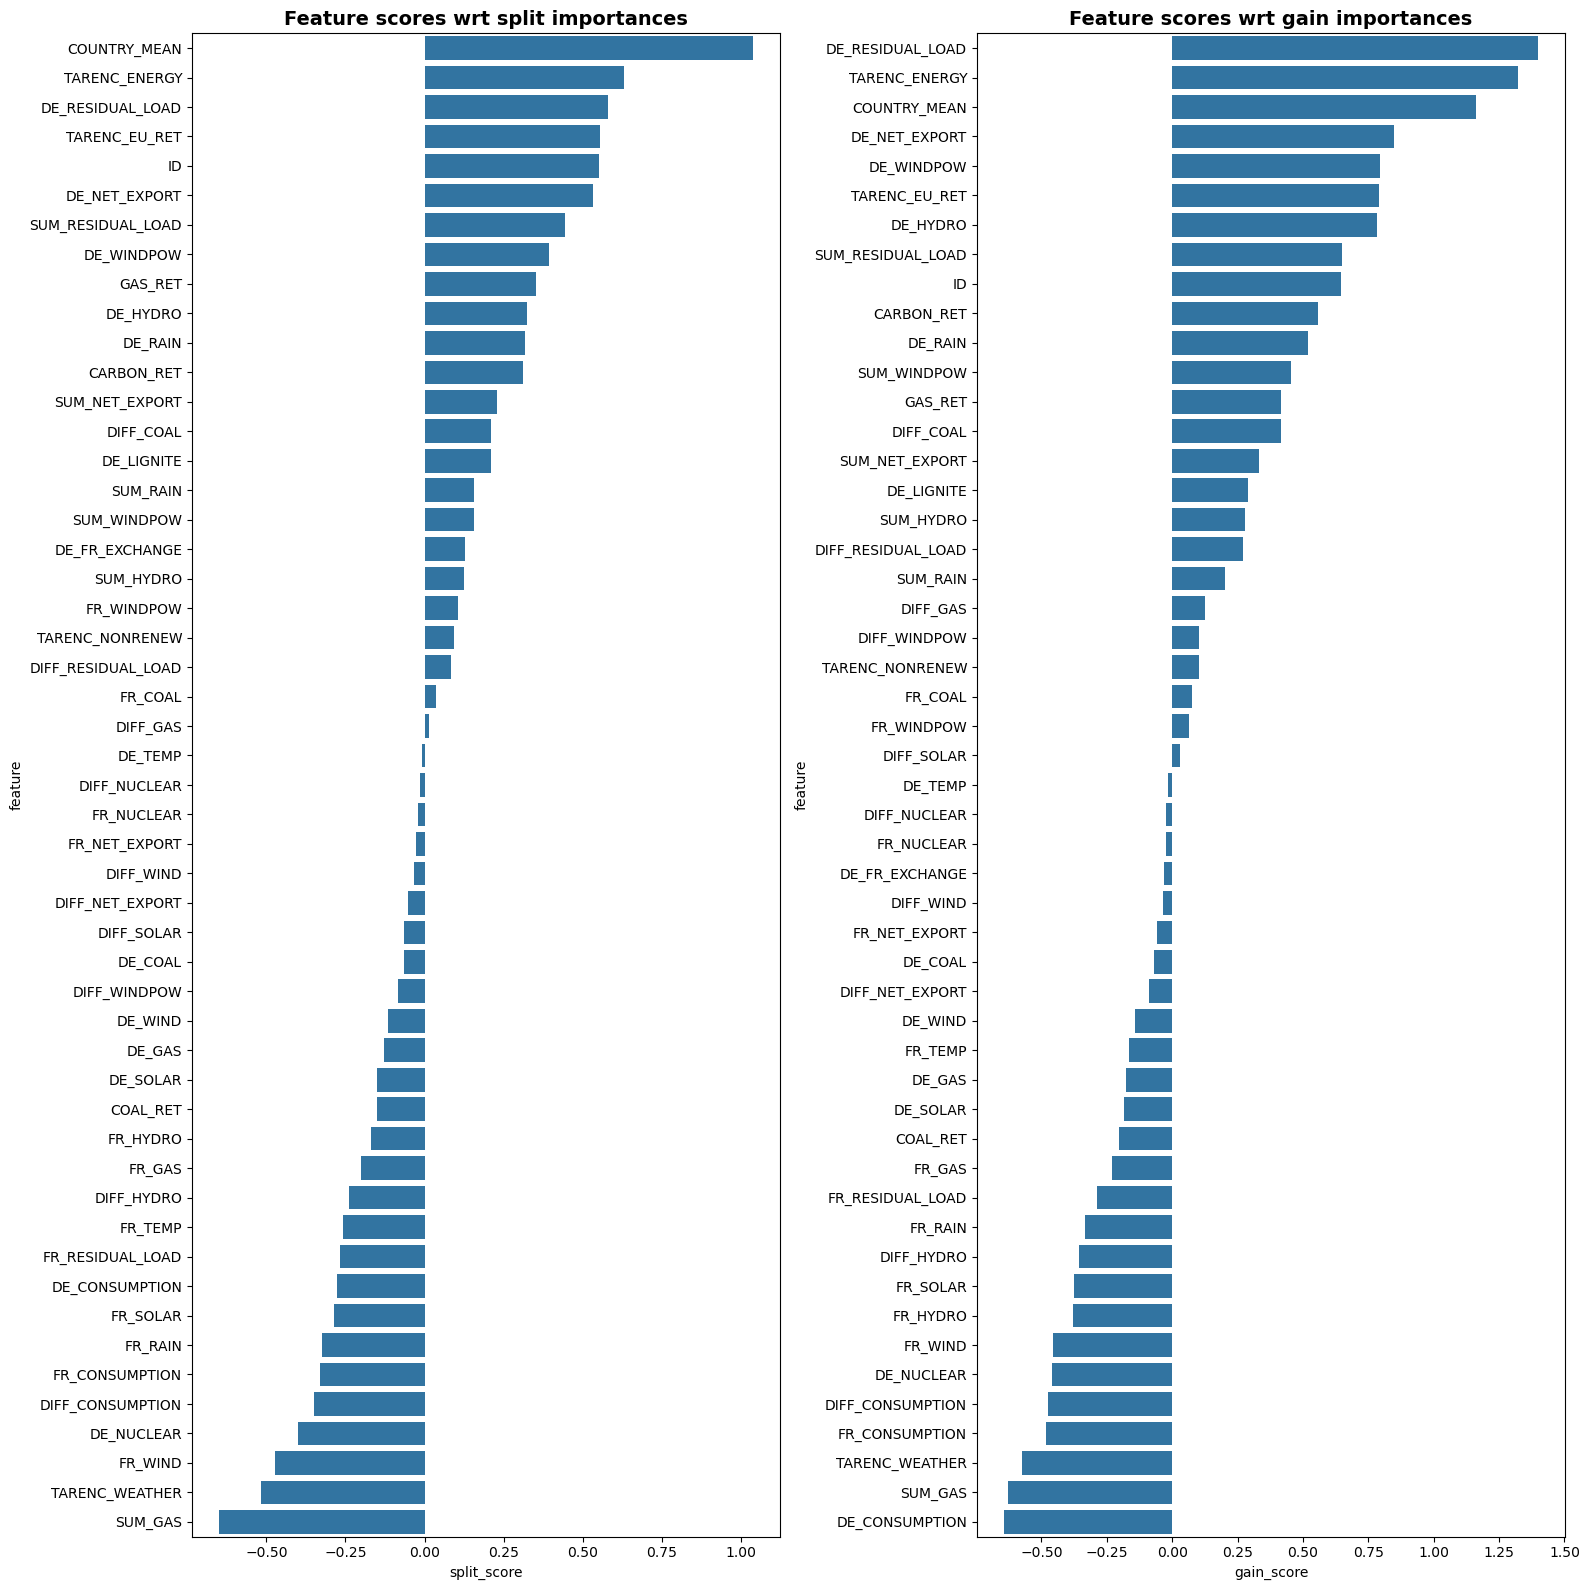

In [63]:
# plot null importances distribution
plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

In [64]:
# compute correlation scores
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

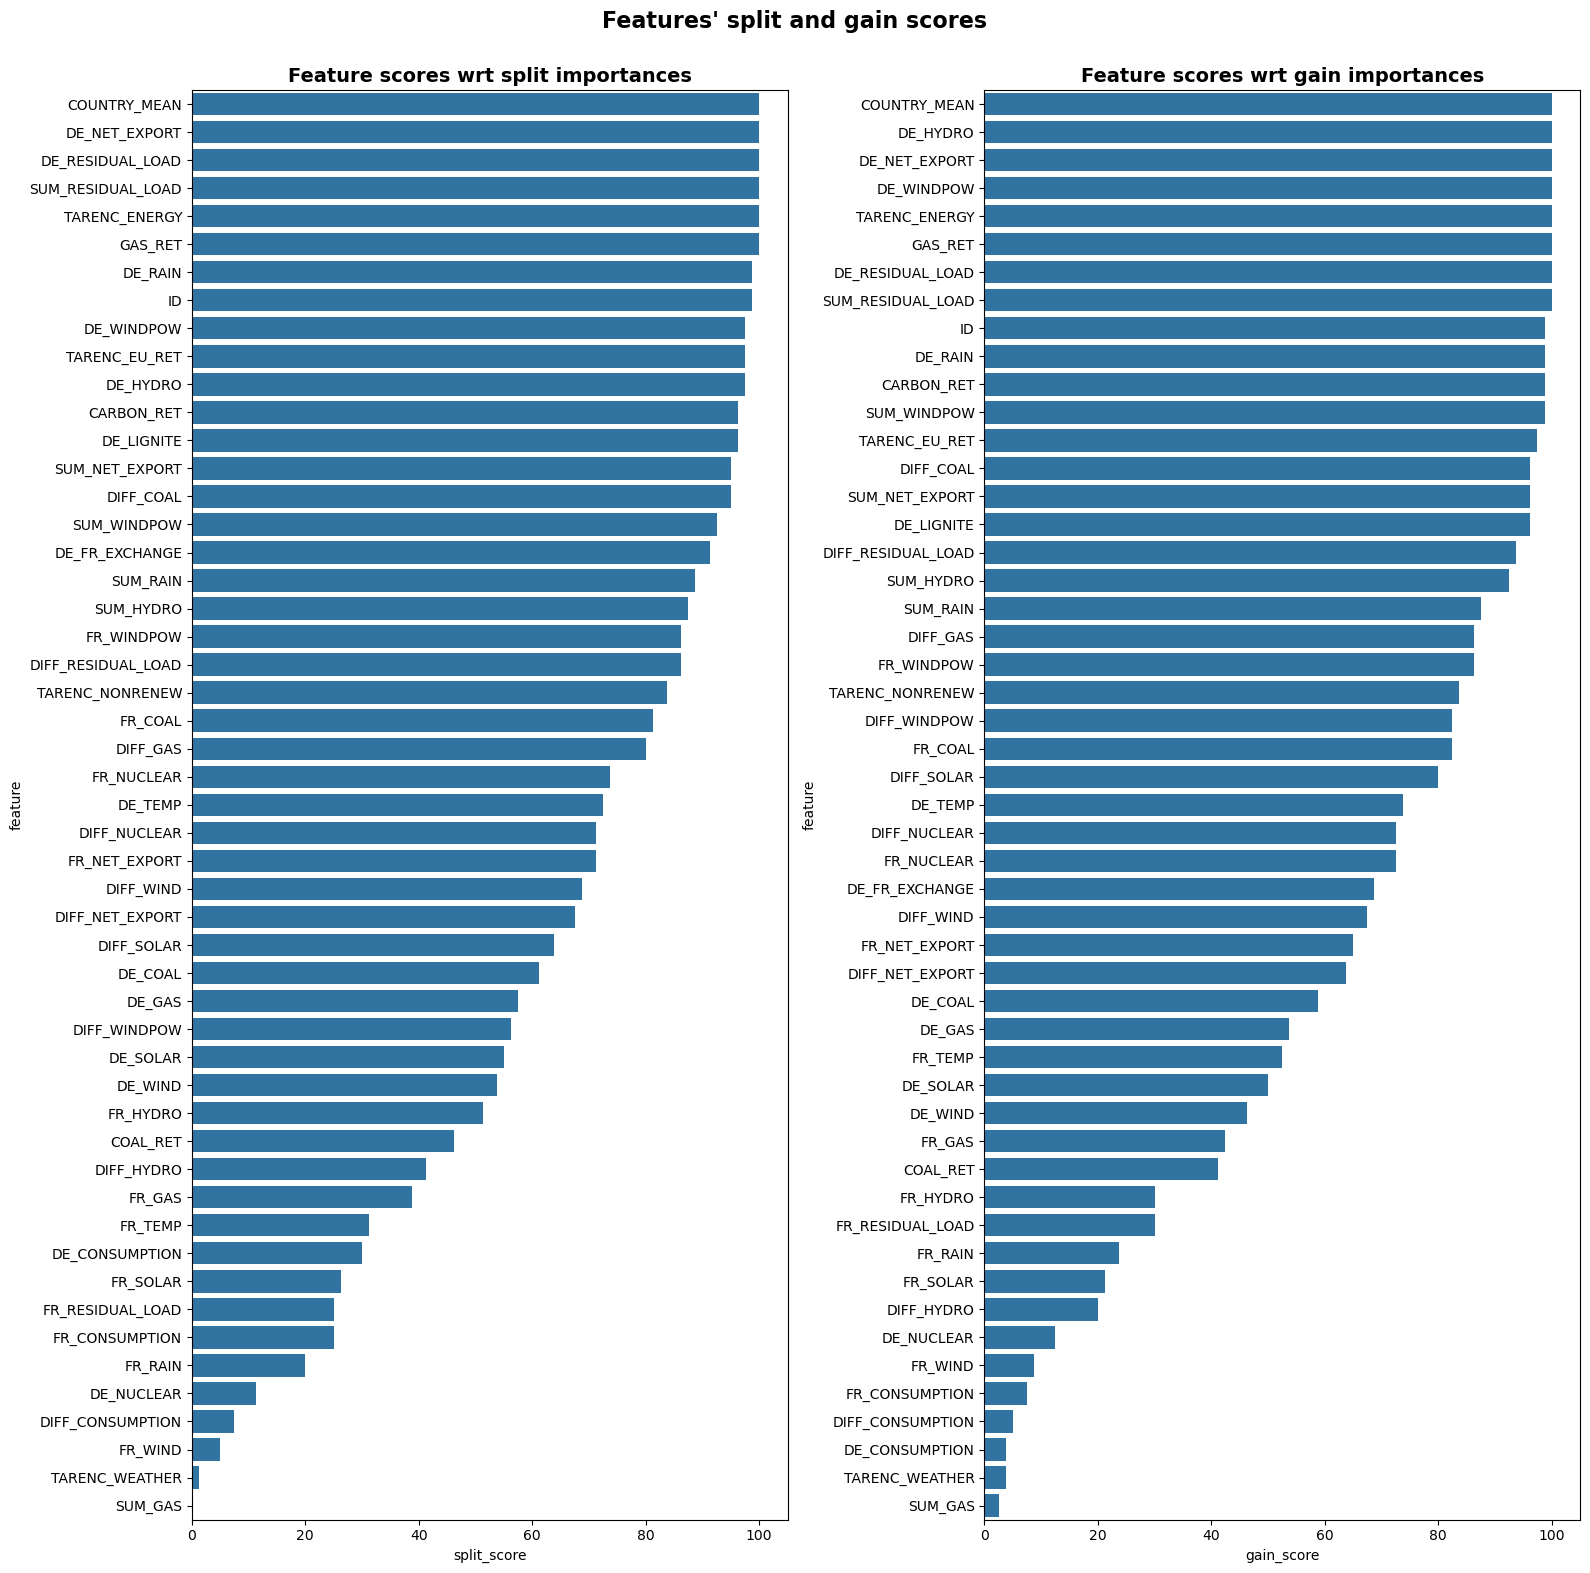

In [65]:
# plot features' split and gain scores
fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

In [66]:
# determine the drop list based on null importance
split_feats = [_f for _f, _score, _ in correlation_scores if _score >= null_importance_threshold]
gain_feats = [_f for _f, _, _score in correlation_scores if _score >= null_importance_threshold]
drop_null_importance = [x for x in split_feats if x in gain_feats]
display(drop_null_importance)

['ID',
 'COUNTRY_MEAN',
 'DE_NET_EXPORT',
 'DE_HYDRO',
 'DE_WINDPOW',
 'DE_LIGNITE',
 'DE_RESIDUAL_LOAD',
 'DE_RAIN',
 'GAS_RET',
 'CARBON_RET',
 'TARENC_EU_RET',
 'TARENC_ENERGY',
 'DIFF_COAL',
 'SUM_WINDPOW',
 'SUM_RESIDUAL_LOAD',
 'SUM_NET_EXPORT']

In [67]:
# remove selected fea
drop_features += drop_null_importance[1:]
if KeepOrigNumFeatures:
    drop_features = [x for x in drop_features if x not in orig_num_cols]

to_drop = [x for x in drop_features if x in X_trte_finished.columns]
if all(item in X_trte_finished.columns for item in to_drop):
    X_trte_finished.drop(to_drop, axis=1, inplace=True)  
    
Xy_tr_finished = pd.merge(X_trte_finished, y_train, on='ID', how='right')

## 6. Finalize and check the results of feature engineering

Correlation matrix shape: (43, 43)


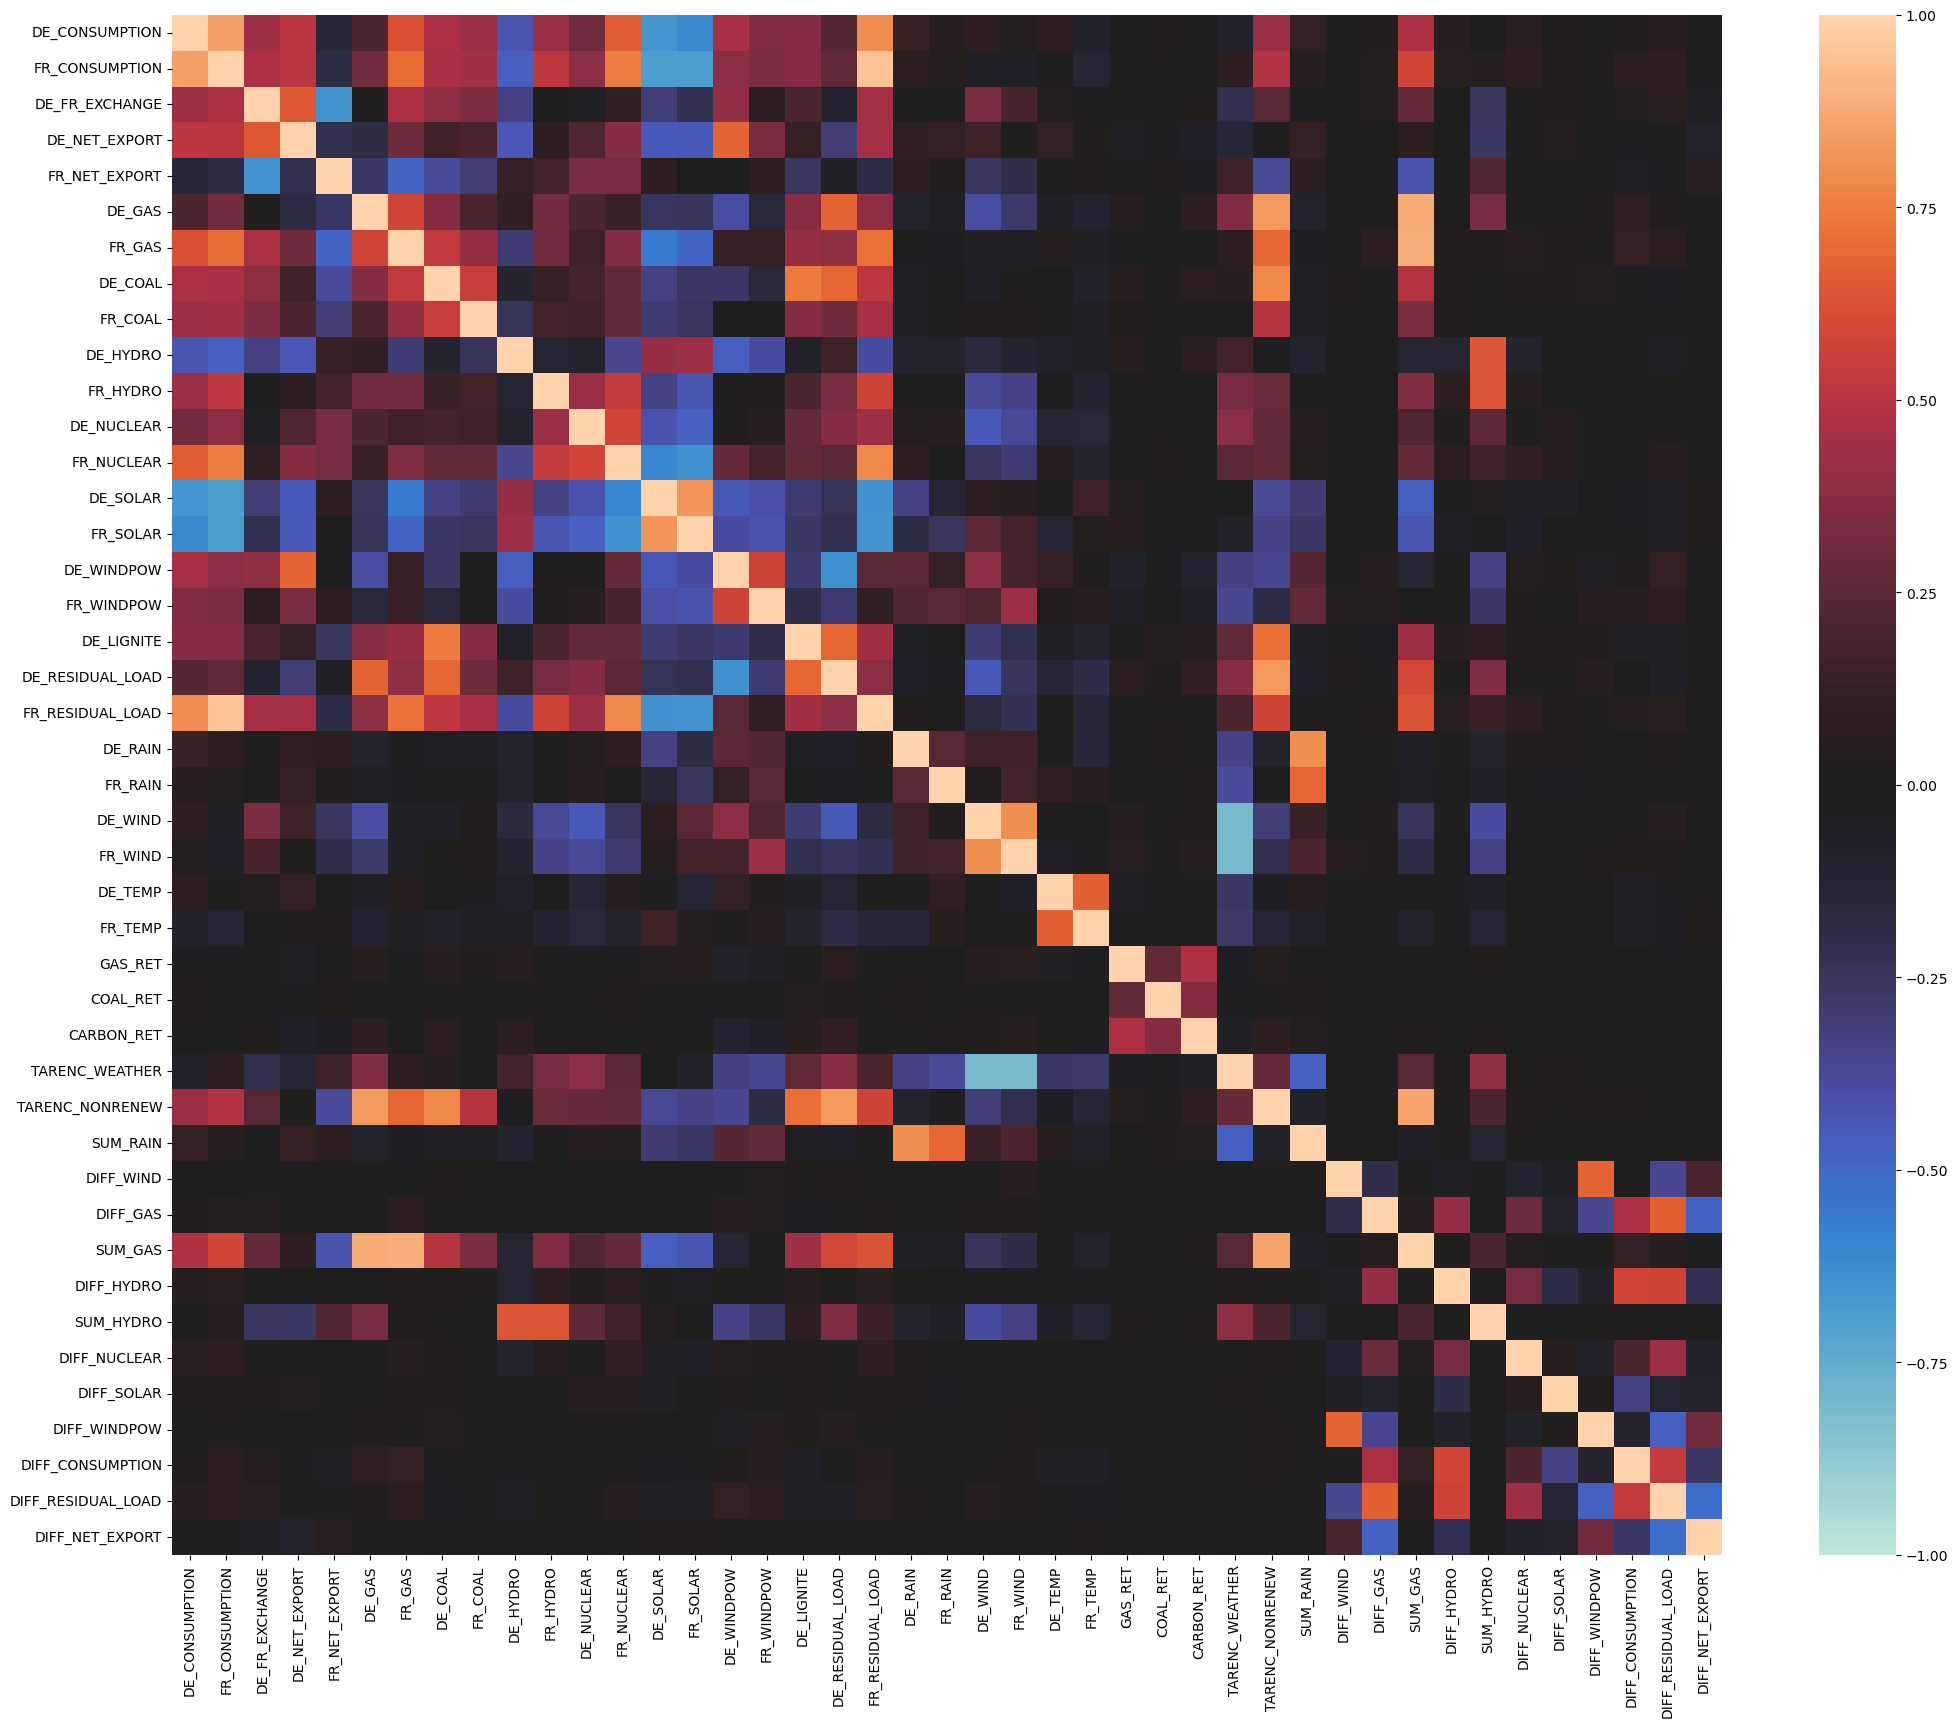

In [68]:
# plot heatmap of train and test data set after feature selection
corr = X_trte_finished.drop('ID', axis=1).corr(parameters['corr_method'])
print("Correlation matrix shape:", corr.shape)

plt.figure(figsize=[25,20])
sns.heatmap(corr, annot=False, vmin=-1, vmax=1, center=0) 
plt.show()

In [69]:
# top correlated pairs by |r|
pairs = []
cols = corr.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        r = corr.iloc[i, j]
        pairs.append((cols[i], cols[j], abs(r), r))
pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)[:60]
pd_pairs_corr = pd.DataFrame(pairs_sorted, columns=["feat1", "feat2", "|r|", "r"])
pd_pairs_high_corr = pd_pairs_corr[pd_pairs_corr['|r|'] >= 0.80]
pd_pairs_high_corr

feat1             feat2       |r|         r
0     FR_CONSUMPTION  FR_RESIDUAL_LOAD  0.948533  0.948533
1             FR_GAS           SUM_GAS  0.890381  0.890381
2             DE_GAS           SUM_GAS  0.876269  0.876269
3    TARENC_NONRENEW           SUM_GAS  0.853580  0.853580
4     DE_CONSUMPTION    FR_CONSUMPTION  0.850321  0.850321
5             DE_GAS   TARENC_NONRENEW  0.833975  0.833975
6   DE_RESIDUAL_LOAD   TARENC_NONRENEW  0.822407  0.822407
7           DE_SOLAR          FR_SOLAR  0.815540  0.815540
8            FR_WIND    TARENC_WEATHER  0.810122 -0.810122
9            DE_WIND    TARENC_WEATHER  0.805946 -0.805946
10           DE_RAIN          SUM_RAIN  0.803826  0.803826
11           DE_WIND           FR_WIND  0.802614  0.802614

Correlation matrix shape: (44, 44)


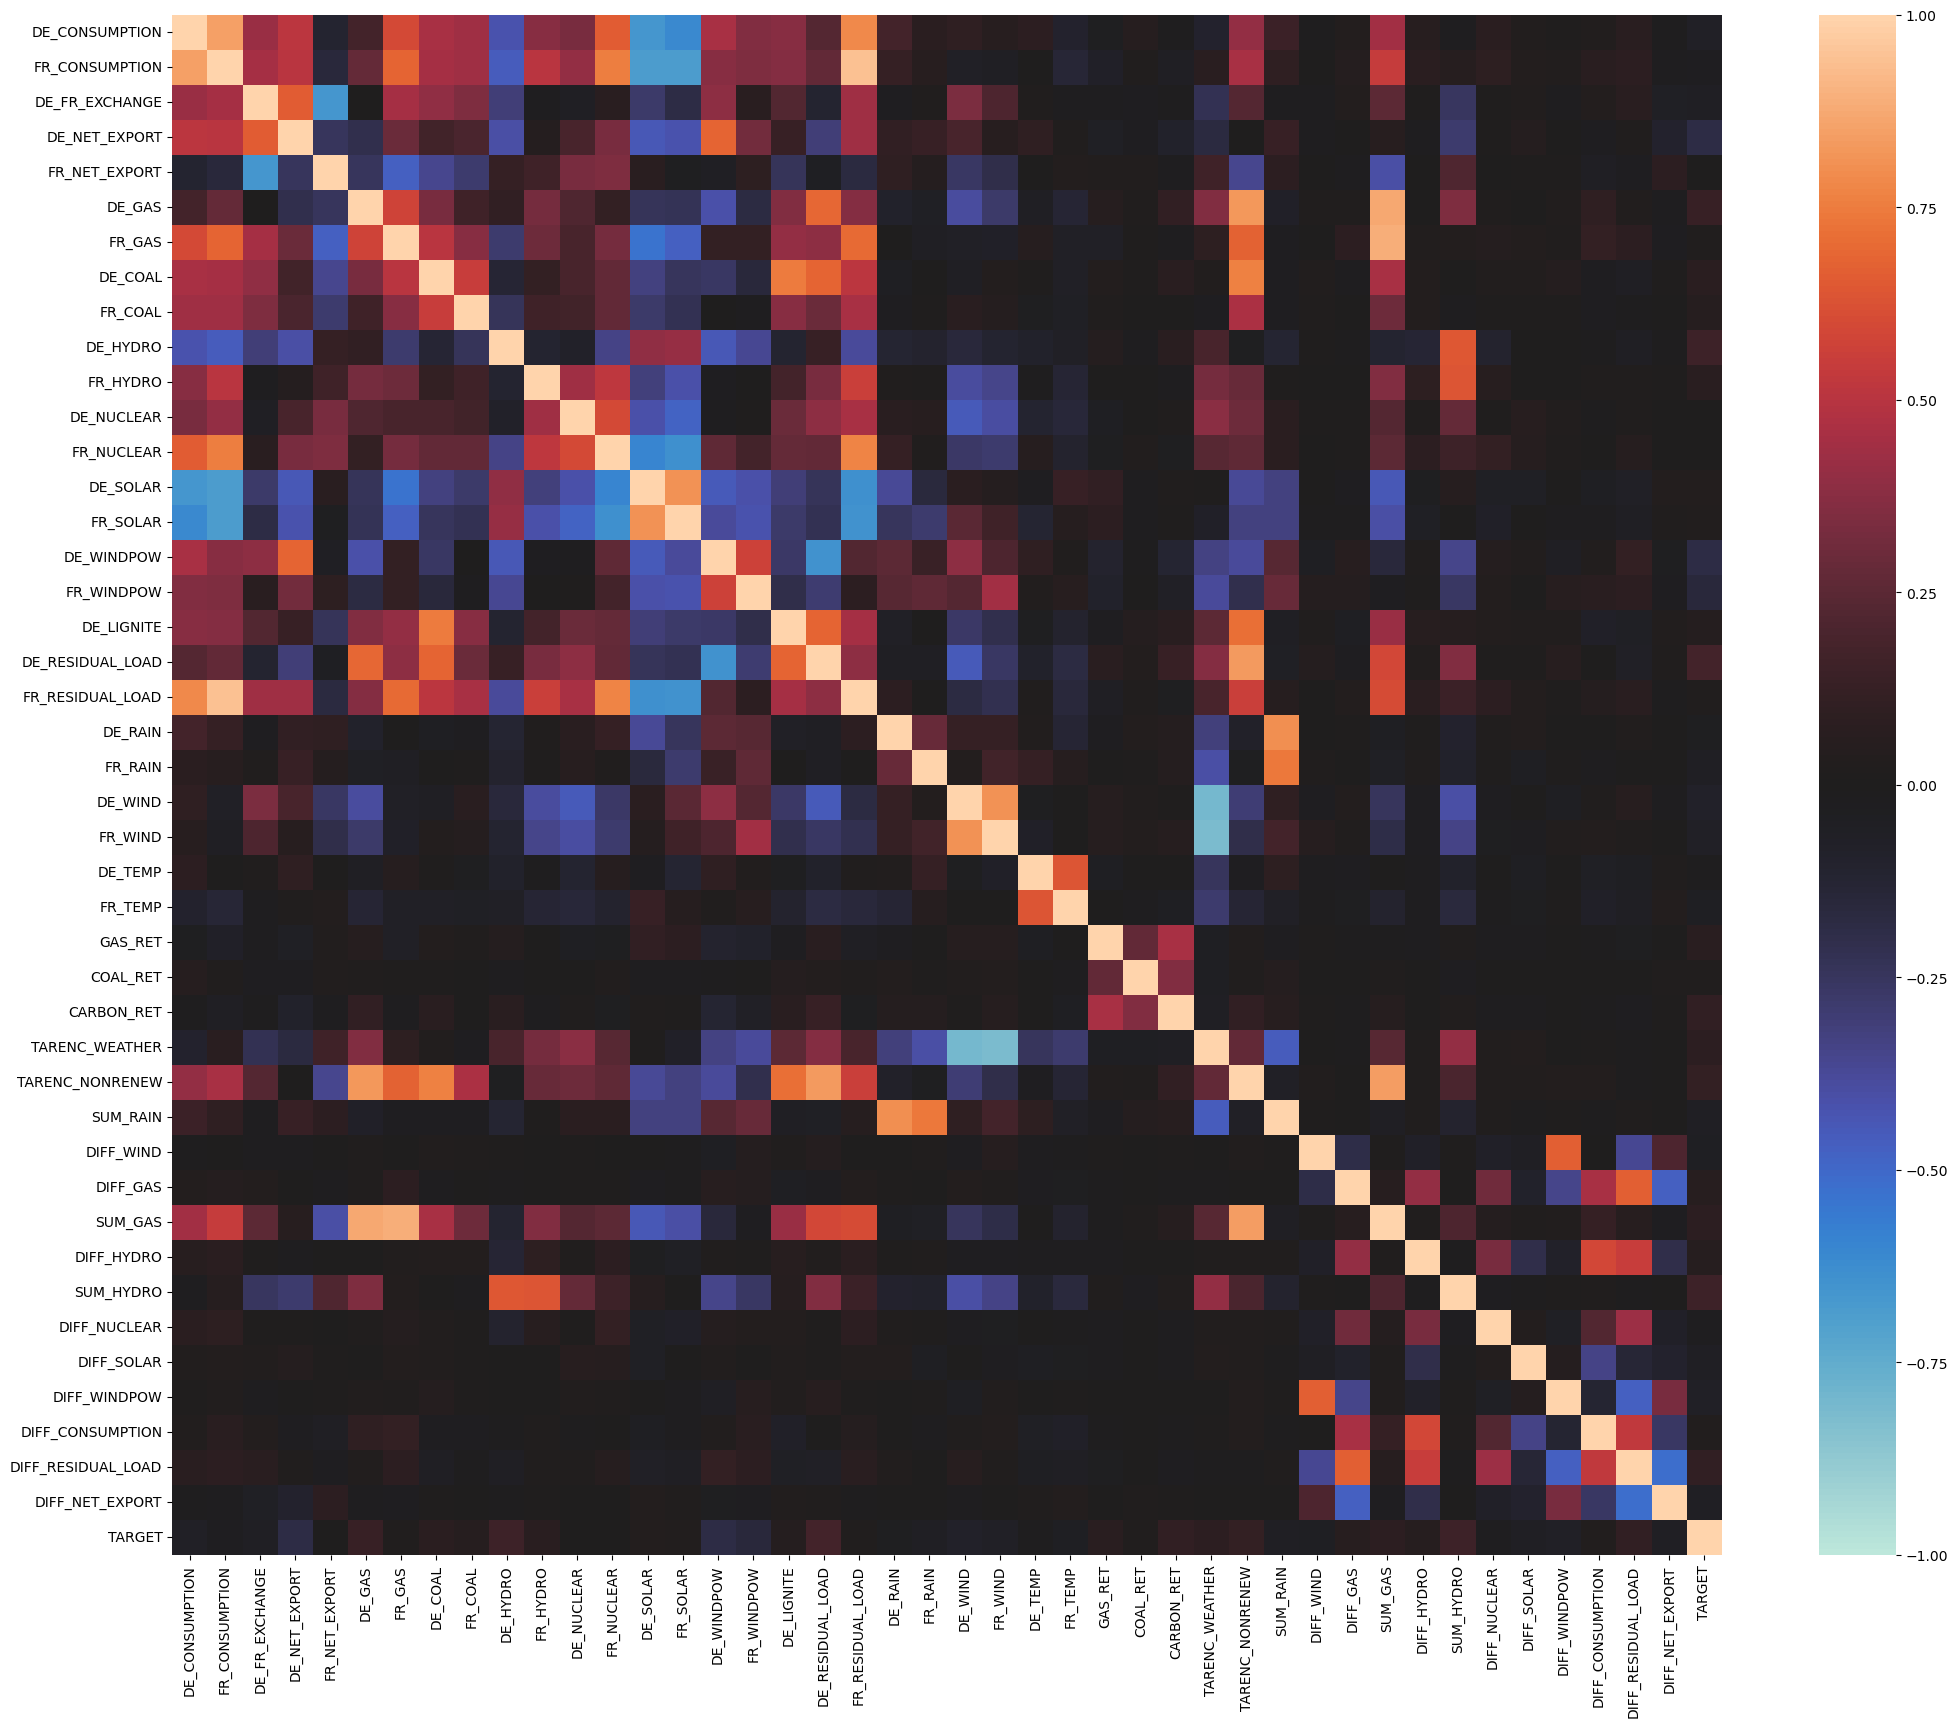

In [70]:
# plot heatmap of train data set with target after feature selection
corr = Xy_tr_finished.drop('ID', axis=1).corr(parameters['corr_method'])
print("Correlation matrix shape:", corr.shape)

plt.figure(figsize=[25,20])
sns.heatmap(corr, annot=False, vmin=-1, vmax=1, center=0) 
plt.show()

DE_RESIDUAL_LOAD      0.175793
SUM_HYDRO             0.152320
DE_HYDRO              0.151367
DE_GAS                0.129905
TARENC_NONRENEW       0.111437
DIFF_RESIDUAL_LOAD    0.106547
CARBON_RET            0.104375
TARENC_WEATHER        0.080359
SUM_GAS               0.079039
DE_COAL               0.072380
GAS_RET               0.066800
FR_HYDRO              0.064682
DIFF_GAS              0.060776
FR_COAL               0.048463
DIFF_HYDRO            0.047350
DE_LIGNITE            0.044180
DE_SOLAR              0.032740
FR_SOLAR              0.028839
DIFF_CONSUMPTION      0.024143
FR_RESIDUAL_LOAD      0.018241
COAL_RET              0.017573
FR_GAS                0.016334
DE_NUCLEAR            0.007052
FR_NET_EXPORT         0.002212
FR_NUCLEAR           -0.003619
DE_TEMP              -0.013885
DIFF_NUCLEAR         -0.020674
FR_CONSUMPTION       -0.027242
DE_RAIN              -0.036054
DIFF_WIND            -0.039104
FR_TEMP              -0.041060
SUM_RAIN             -0.050081
DIFF_SOL

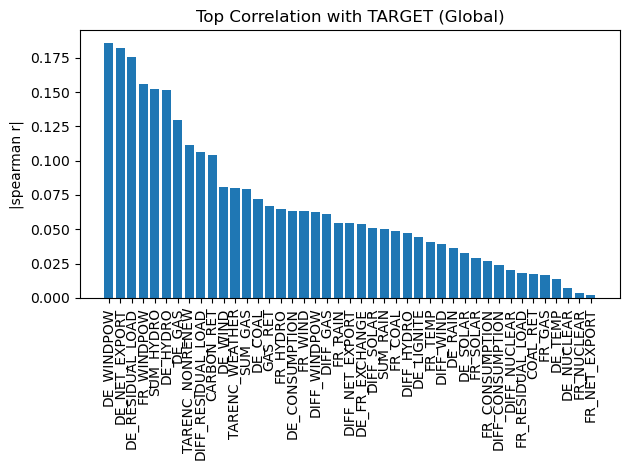

In [71]:
# plot high correlation with target
assert "TARGET" in Xy_tr_finished.columns, "TARGET missing after merge"
target_corr = Xy_tr_finished.drop('ID', axis=1).corr(method=parameters['corr_method'])["TARGET"].drop("TARGET").sort_values(ascending=False)
display(target_corr)

# bar of absolute correlations (top-k)
tc_abs = target_corr.abs().sort_values(ascending=False)
plt.figure()
plt.bar(tc_abs.index.astype(str), tc_abs.values)
plt.xticks(rotation=90)
plt.ylabel(f"|{parameters['corr_method']} r|")
plt.title("Top Correlation with TARGET (Global)")
plt.tight_layout()
plt.show()

DE_RESIDUAL_LOAD      0.061287
DE_WINDPOW            0.057267
SUM_HYDRO             0.055135
FR_NET_EXPORT         0.049652
DE_WIND               0.047819
DE_LIGNITE            0.043404
DE_RAIN               0.042970
DE_GAS                0.033928
DIFF_WIND             0.032239
FR_CONSUMPTION        0.029868
SUM_RAIN              0.029496
DIFF_RESIDUAL_LOAD    0.024380
DE_TEMP               0.023047
DIFF_SOLAR            0.022829
DIFF_NET_EXPORT       0.021277
FR_WINDPOW            0.020668
FR_WIND               0.020436
DIFF_WINDPOW          0.020376
FR_SOLAR              0.019102
GAS_RET               0.018954
DE_NUCLEAR            0.018599
DE_CONSUMPTION        0.017685
TARENC_NONRENEW       0.017232
DIFF_CONSUMPTION      0.016604
FR_COAL               0.016442
DIFF_NUCLEAR          0.016105
FR_NUCLEAR            0.015078
DIFF_HYDRO            0.013604
CARBON_RET            0.013371
DE_COAL               0.010477
FR_RAIN               0.009210
SUM_GAS               0.007126
FR_HYDRO

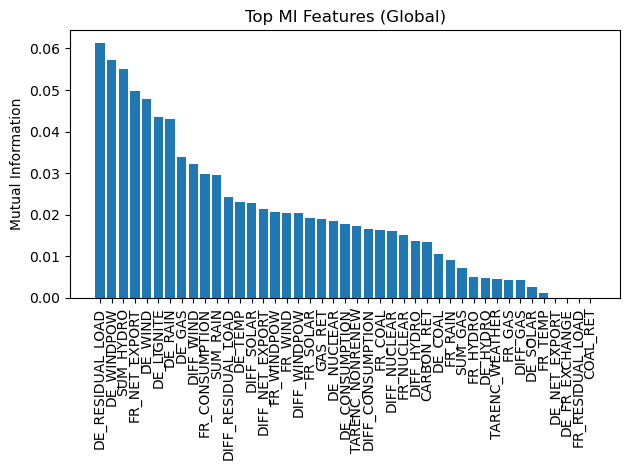

In [72]:
# plot mutual information ranking (top-k)
mi = mutual_info_regression(Xy_tr_finished.drop(['ID', 'TARGET'], axis=1), Xy_tr_finished['TARGET'], random_state=RANDOM_STATE)
mi_series = pd.Series(mi, index=Xy_tr_finished.columns[1:-1]).sort_values(ascending=False)
display(mi_series)

plt.figure()
plt.bar(mi_series.index.astype(str), mi_series.values)
plt.xticks(rotation=90)
plt.ylabel("Mutual Information")
plt.title("Top MI Features (Global)")
plt.tight_layout()
plt.show()

In [73]:
# finalize the engineered data set
if OnlyOrigNumFeatures:
    remain_features = [x for x in X_trte_finished.columns if x in orig_num_cols]
    X_trte_finished = X_trte_finished[remain_features]
    X_trte_finished['DE_NET_IMPORT'] = -1 * X_trte_finished['DE_NET_EXPORT']
    X_trte_finished['FR_NET_IMPORT'] = -1 * X_trte_finished['FR_NET_EXPORT']
    X_trte_finished['FR_DE_EXCHANGE'] = -1 * X_trte_finished['DE_FR_EXCHANGE']

X_train_clean = X_train[['ID']].merge(X_trte_finished, on='ID', how='left')
X_test_clean = X_test[['ID']].merge(X_trte_finished, on='ID', how='left')

print("Missing value count:", X_train_clean.isna().sum().sum() + X_test_clean.isna().sum().sum())
display(X_train_clean.shape)
display(X_test_clean.shape)
display(y_train.shape)

Missing value count: 0


(1494, 33)

(654, 33)

(1494, 2)

## 7. Evaluate the feature engineering result with ML prediction

In [74]:
# TabPFN regression
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train_clean, y_train['TARGET'], test_size=0.15, random_state=RANDOM_STATE)

tabpfn_regressor = TabPFNRegressor(random_state=42, device="cuda")
tabpfn_regressor.fit(X_train_.to_numpy(), y_train_.to_numpy())
test_pred = tabpfn_regressor.predict(X_test_)

mse = mean_squared_error(y_test_, test_pred)
spearman = spearmanr(y_test_, test_pred).correlation
r2 = r2_score(y_test_, test_pred)

print(f"RMSE on test set: {mse:.4f}")
print(f"Spearmanon correlation on test set: {spearmanr(y_test_, test_pred).correlation}")

sb.glue("spearman", spearman)                 
sb.glue("r2", r2)  
sb.glue("X_train", X_train_clean)                 
sb.glue("y_train", y_train)  
sb.glue("X_test", X_test_clean)                 

RMSE on test set: 1.0145
Spearmanon correlation on test set: 0.3475189633375475
